# Pytorch Object Discovery Autoencoder

Notebook from **Lukas Heinrich** implementing the [slot attention](https://arxiv.org/abs/2006.15055) module for object discovery in pytorch.

Summer 2023

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

In [ ]:
def gen_data():
    bins = [np.linspace(-7,7,41)]*2
    _ed = np.linspace(-7,7,41)
    _ct = _ed[:-1] + np.diff(_ed)/2
    grid = np.meshgrid(*[_ct]*2, indexing='ij')

    
    K = 2
    centers = np.random.uniform(-6,6, size = (K, 2))
    X = np.concatenate([np.random.multivariate_normal(cc,0.2*np.eye(2), size = (1000,)) for cc in centers])
    c,_,_= np.histogram2d(X[:,0], X[:,1], bins = bins)
    c = np.log(c + 1e-2)
    c = np.stack([grid[0],grid[1],1-grid[0],1-grid[1],c])
    return torch.FloatTensor(c)[None,:], torch.FloatTensor(centers)[None,:]

def make_batch(
        Nbatch = 34,
        data_mean = torch.FloatTensor([0,0,0,0,3]),
        data_std = torch.FloatTensor([1,1,1,1,1])
    ):
    batch = [gen_data() for i in range(Nbatch)]
    data = torch.concat([b[0] for b in batch])
    trgt = torch.concat([b[1] for b in batch])
    
    bkgtrgt = -3*torch.ones(Nbatch,1,2)
    return data, trgt
make_batch(123)[0].shape

In [ ]:
class TrivialSlotEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 2
                
        self.hidden_dim = 4
        self.encoder1 = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )
        self.encoder2 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(40*40*self.hidden_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,self.latent_dim)
        )   
        
    def forward(self, data):
        encoded_data = self.encoder1(data)
        positions = self.encoder2(encoded_data)
        positions = positions.unsqueeze(1)
        return positions

In [5]:
class SlotAttentionEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.k_slots = 3
        self.latent_dim = 32
        self.hidden_dim = 32
        self.query_dim = 32
        self.slot_dim = 32
        self.n_iter = 1

        self.queryN = torch.nn.LayerNorm(self.query_dim)
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.updateN = torch.nn.LayerNorm(self.query_dim)

        self.toK = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )   
        
        self.final = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.slot_dim)
        )

        self.updateff = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.query_dim)
        )
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim)
        
        mu = torch.zeros(1,1,self.query_dim)
        logsigma = torch.zeros(1,1,self.query_dim)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        att = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        att = torch.nn.functional.softmax(att, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)        
        vals = self.toV(encoded_data)
        extracted = torch.einsum('bsd,bde->bse',wts,vals)
        
        extracted = self.gru(
            extracted.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        extracted = extracted.reshape(queries.shape)
        return extracted + self.updateff(self.updateN(extracted))
    
    def forward(self, data):
        Nbatch = data.shape[0]
        queries = self.init_slots(Nbatch)
        encoded_data = self.encoder(data)
        queries = self.iterate(queries, encoded_data)
        queries = self.iterate(queries, encoded_data)
        positions = self.final(queries)
        return positions,queries
        
SlotAttentionEncoder()(torch.randn(123,5,40,40))[0].shape

torch.Size([123, 3, 32])

In [6]:
TrivialSlotEncoder()(torch.randn(123,5,40,40)).shape

torch.Size([123, 1, 2])

In [7]:
class AttModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 32

        self.encoder = SlotAttentionEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,40*40),
            torch.nn.Unflatten(-1,(40,40))
        )
        

    def forward(self, data):
        Nbatch, *_ = data.shape
        positions,queries = self.encoder(data)
        decoded = self.decoder(positions)
        reco = decoded.sum(dim = 1)
        return reco,queries,decoded

AttModel().encoder(make_batch(123)[0])[0].shape

torch.Size([123, 3, 32])

In [8]:
def plotit(batchidx, model, data, losses):
    with torch.no_grad():
        model.eval()
        pred,queries,decoded = model(data)
        encoded_data = model.encoder.encoder(data)
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = model.encoder.dataN(encoded_data)
        att,wts = model.encoder.attention_and_weights(queries,encoded_data)
#         print(wts.sum(dim=-1).max(),'max')
        att = att.reshape(len(att),3,40,40)
        wts = wts.reshape(len(att),3,40,40)
        
        crap = model.decoder(torch.randn(2,model.encoder.k_slots,model.encoder.slot_dim))
        
    f,axarr = plt.subplots(3,6)
    ax = axarr[0,0]
    ax.plot(losses)
    ax.set_yscale('log')
    ax.axis('off')
    ax = axarr[0,1]
    ax.pcolormesh(data[batchidx,-1], vmin = -3, vmax = 3)
    ax.axis('off')
    ax = axarr[0,2]
    ax.pcolormesh(pred[batchidx], vmin = -3, vmax = 3)
    ax.axis('off')
    for i in range(3):
        ax = axarr[0,3+i]
        ax.pcolormesh(att[batchidx,i], vmin = 0, vmax = 1)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,3+i]
        print(wts.min(),wts.max(),'>>><<')
        ax.pcolormesh(wts[batchidx,i], vmin = 0, vmax = .001)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,i]
        ax.axis('off')
        ax = axarr[2,i]
        ax.axis('off')
    ax = axarr[1,0]
    ax.pcolormesh(crap[batchidx,0])

    ax = axarr[1,2]
    ax.pcolormesh(decoded.sum(dim=1)[batchidx], vmin = -3, vmax = 3)
    for i in range(3):
        ax = axarr[2,3+i]
        ax.pcolormesh(decoded[batchidx,i], vmin = -3, vmax = 3)
        ax.axis('off')
    f.set_size_inches(6,3)
    plt.show()    

def train(model, Ntrain = 5000):
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    model.train()
    losses = []
    for i in range(Ntrain):
        
        warmup_steps = 5000
        learning_rate = 3e-4
        if i < warmup_steps:
            learning_rate = learning_rate * (i / warmup_steps)
        else:
            learning_rate = learning_rate
        opt.param_groups[0]['lr'] = learning_rate

        
        data, trgt = make_batch(4)
        pred,*_ = model(data)
        loss = torch.nn.functional.mse_loss(
            data[:,-1,...],
            pred
        )
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('loss',i,loss,opt.param_groups[0]['lr'])
            plotit(0,model,data,losses)
            plotit(1,model,data,losses)

    model.eval()
    return model,losses

In [9]:
model = AttModel()

loss 0 tensor(20.2506, grad_fn=<MseLossBackward0>) 0.0
tensor(2.1533e-08) tensor(0.0066) >>><<
tensor(2.1533e-08) tensor(0.0066) >>><<
tensor(2.1533e-08) tensor(0.0066) >>><<


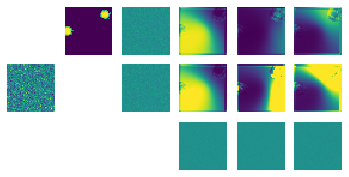

tensor(1.3202e-08) tensor(0.0069) >>><<
tensor(1.3202e-08) tensor(0.0069) >>><<
tensor(1.3202e-08) tensor(0.0069) >>><<


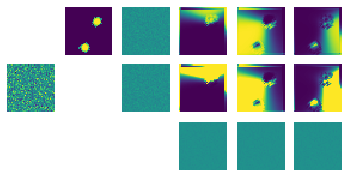

loss 250 tensor(19.4552, grad_fn=<MseLossBackward0>) 1.4999999999999999e-05
tensor(1.0142e-08) tensor(0.0066) >>><<
tensor(1.0142e-08) tensor(0.0066) >>><<
tensor(1.0142e-08) tensor(0.0066) >>><<


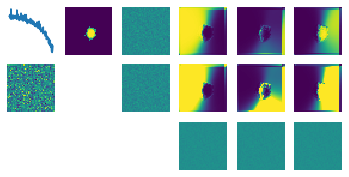

tensor(1.3774e-07) tensor(0.0079) >>><<
tensor(1.3774e-07) tensor(0.0079) >>><<
tensor(1.3774e-07) tensor(0.0079) >>><<


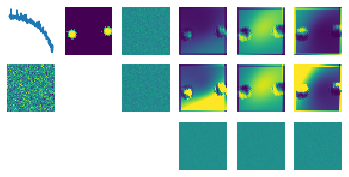

loss 500 tensor(3.2049, grad_fn=<MseLossBackward0>) 2.9999999999999997e-05
tensor(6.2604e-08) tensor(0.0061) >>><<
tensor(6.2604e-08) tensor(0.0061) >>><<
tensor(6.2604e-08) tensor(0.0061) >>><<


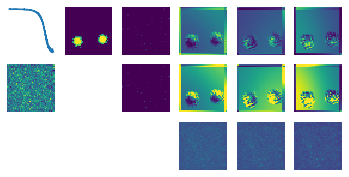

tensor(1.4984e-08) tensor(0.0027) >>><<
tensor(1.4984e-08) tensor(0.0027) >>><<
tensor(1.4984e-08) tensor(0.0027) >>><<


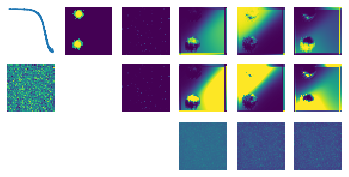

loss 750 tensor(3.1174, grad_fn=<MseLossBackward0>) 4.4999999999999996e-05
tensor(2.4571e-07) tensor(0.0044) >>><<
tensor(2.4571e-07) tensor(0.0044) >>><<
tensor(2.4571e-07) tensor(0.0044) >>><<


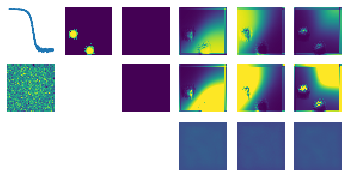

tensor(9.3079e-08) tensor(0.0033) >>><<
tensor(9.3079e-08) tensor(0.0033) >>><<
tensor(9.3079e-08) tensor(0.0033) >>><<


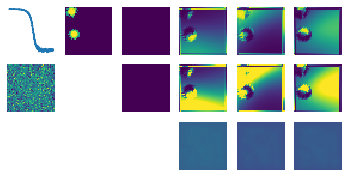

loss 1000 tensor(2.9238, grad_fn=<MseLossBackward0>) 5.9999999999999995e-05
tensor(1.2677e-07) tensor(0.0034) >>><<
tensor(1.2677e-07) tensor(0.0034) >>><<
tensor(1.2677e-07) tensor(0.0034) >>><<


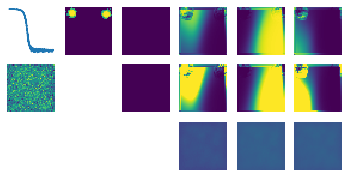

tensor(1.4388e-08) tensor(0.0054) >>><<
tensor(1.4388e-08) tensor(0.0054) >>><<
tensor(1.4388e-08) tensor(0.0054) >>><<


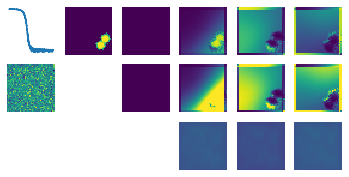

loss 1250 tensor(2.8885, grad_fn=<MseLossBackward0>) 7.5e-05
tensor(4.1977e-07) tensor(0.0034) >>><<
tensor(4.1977e-07) tensor(0.0034) >>><<
tensor(4.1977e-07) tensor(0.0034) >>><<


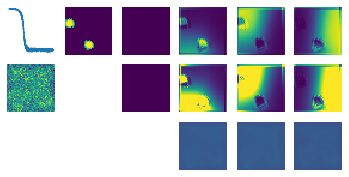

tensor(4.5381e-07) tensor(0.0045) >>><<
tensor(4.5381e-07) tensor(0.0045) >>><<
tensor(4.5381e-07) tensor(0.0045) >>><<


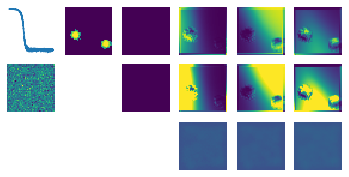

loss 1500 tensor(2.9740, grad_fn=<MseLossBackward0>) 8.999999999999999e-05
tensor(1.1211e-06) tensor(0.0030) >>><<
tensor(1.1211e-06) tensor(0.0030) >>><<
tensor(1.1211e-06) tensor(0.0030) >>><<


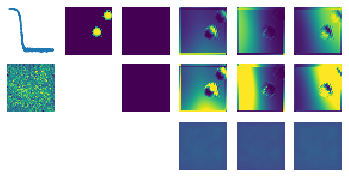

tensor(9.1321e-08) tensor(0.0032) >>><<
tensor(9.1321e-08) tensor(0.0032) >>><<
tensor(9.1321e-08) tensor(0.0032) >>><<


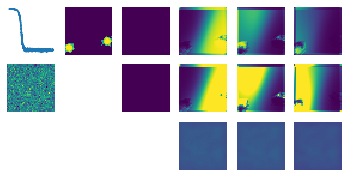

loss 1750 tensor(2.8664, grad_fn=<MseLossBackward0>) 0.00010499999999999999
tensor(9.9217e-08) tensor(0.0032) >>><<
tensor(9.9217e-08) tensor(0.0032) >>><<
tensor(9.9217e-08) tensor(0.0032) >>><<


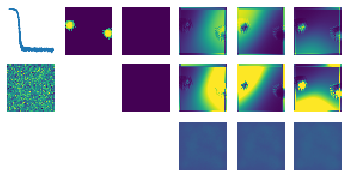

tensor(2.5864e-07) tensor(0.0036) >>><<
tensor(2.5864e-07) tensor(0.0036) >>><<
tensor(2.5864e-07) tensor(0.0036) >>><<


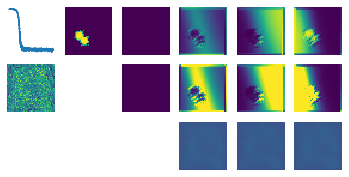

loss 2000 tensor(2.6890, grad_fn=<MseLossBackward0>) 0.00011999999999999999
tensor(8.8222e-08) tensor(0.0023) >>><<
tensor(8.8222e-08) tensor(0.0023) >>><<
tensor(8.8222e-08) tensor(0.0023) >>><<


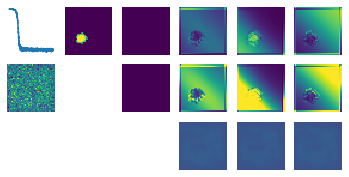

tensor(1.1238e-07) tensor(0.0054) >>><<
tensor(1.1238e-07) tensor(0.0054) >>><<
tensor(1.1238e-07) tensor(0.0054) >>><<


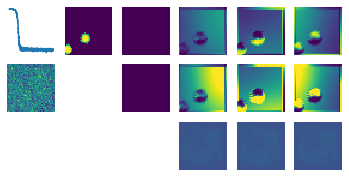

loss 2250 tensor(2.8778, grad_fn=<MseLossBackward0>) 0.000135
tensor(1.4919e-08) tensor(0.0030) >>><<
tensor(1.4919e-08) tensor(0.0030) >>><<
tensor(1.4919e-08) tensor(0.0030) >>><<


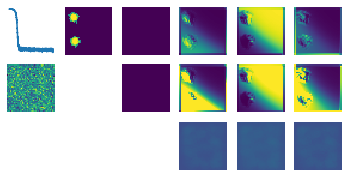

tensor(1.0053e-06) tensor(0.0048) >>><<
tensor(1.0053e-06) tensor(0.0048) >>><<
tensor(1.0053e-06) tensor(0.0048) >>><<


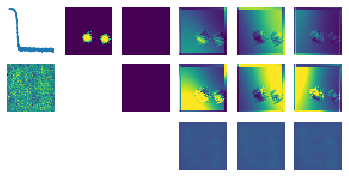

loss 2500 tensor(2.8326, grad_fn=<MseLossBackward0>) 0.00015
tensor(1.5025e-08) tensor(0.0029) >>><<
tensor(1.5025e-08) tensor(0.0029) >>><<
tensor(1.5025e-08) tensor(0.0029) >>><<


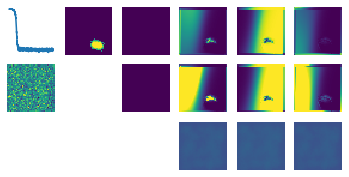

tensor(7.2171e-07) tensor(0.0030) >>><<
tensor(7.2171e-07) tensor(0.0030) >>><<
tensor(7.2171e-07) tensor(0.0030) >>><<


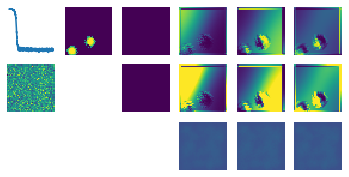

loss 2750 tensor(2.6836, grad_fn=<MseLossBackward0>) 0.000165
tensor(4.9533e-08) tensor(0.0024) >>><<
tensor(4.9533e-08) tensor(0.0024) >>><<
tensor(4.9533e-08) tensor(0.0024) >>><<


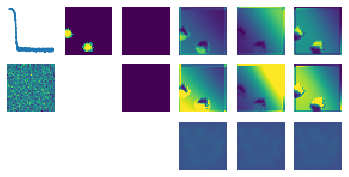

tensor(6.9679e-06) tensor(0.0022) >>><<
tensor(6.9679e-06) tensor(0.0022) >>><<
tensor(6.9679e-06) tensor(0.0022) >>><<


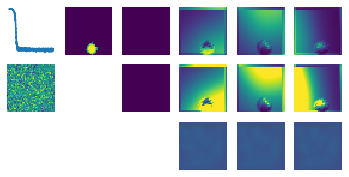

loss 3000 tensor(2.9137, grad_fn=<MseLossBackward0>) 0.00017999999999999998
tensor(3.1376e-07) tensor(0.0022) >>><<
tensor(3.1376e-07) tensor(0.0022) >>><<
tensor(3.1376e-07) tensor(0.0022) >>><<


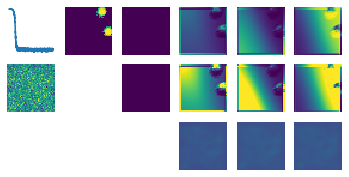

tensor(5.1063e-07) tensor(0.0035) >>><<
tensor(5.1063e-07) tensor(0.0035) >>><<
tensor(5.1063e-07) tensor(0.0035) >>><<


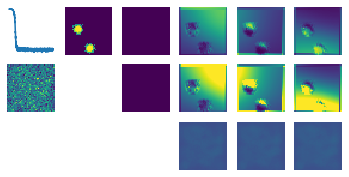

loss 3250 tensor(2.8748, grad_fn=<MseLossBackward0>) 0.000195
tensor(2.7309e-06) tensor(0.0023) >>><<
tensor(2.7309e-06) tensor(0.0023) >>><<
tensor(2.7309e-06) tensor(0.0023) >>><<


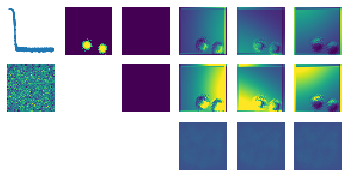

tensor(5.1021e-07) tensor(0.0025) >>><<
tensor(5.1021e-07) tensor(0.0025) >>><<
tensor(5.1021e-07) tensor(0.0025) >>><<


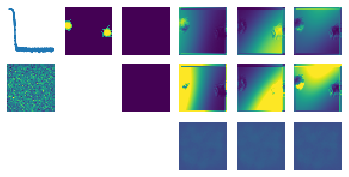

loss 3500 tensor(2.9225, grad_fn=<MseLossBackward0>) 0.00020999999999999998
tensor(1.0700e-05) tensor(0.0027) >>><<
tensor(1.0700e-05) tensor(0.0027) >>><<
tensor(1.0700e-05) tensor(0.0027) >>><<


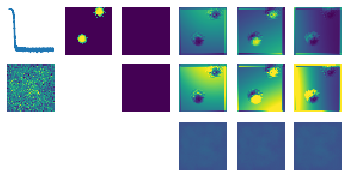

tensor(1.4823e-06) tensor(0.0027) >>><<
tensor(1.4823e-06) tensor(0.0027) >>><<
tensor(1.4823e-06) tensor(0.0027) >>><<


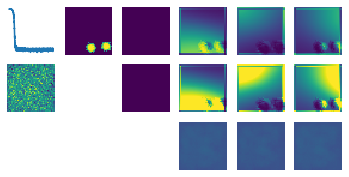

loss 3750 tensor(2.7666, grad_fn=<MseLossBackward0>) 0.000225
tensor(2.2572e-06) tensor(0.0023) >>><<
tensor(2.2572e-06) tensor(0.0023) >>><<
tensor(2.2572e-06) tensor(0.0023) >>><<


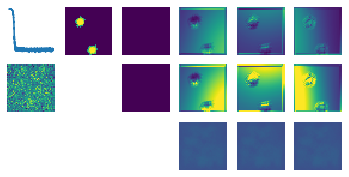

tensor(1.0956e-05) tensor(0.0021) >>><<
tensor(1.0956e-05) tensor(0.0021) >>><<
tensor(1.0956e-05) tensor(0.0021) >>><<


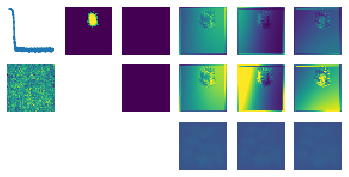

loss 4000 tensor(2.7626, grad_fn=<MseLossBackward0>) 0.00023999999999999998
tensor(3.3927e-07) tensor(0.0022) >>><<
tensor(3.3927e-07) tensor(0.0022) >>><<
tensor(3.3927e-07) tensor(0.0022) >>><<


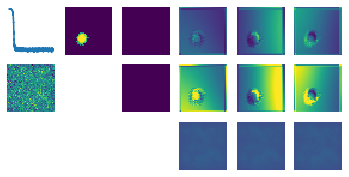

tensor(1.8546e-06) tensor(0.0020) >>><<
tensor(1.8546e-06) tensor(0.0020) >>><<
tensor(1.8546e-06) tensor(0.0020) >>><<


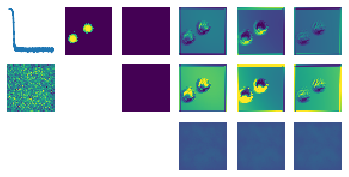

loss 4250 tensor(2.9059, grad_fn=<MseLossBackward0>) 0.00025499999999999996
tensor(8.6292e-06) tensor(0.0024) >>><<
tensor(8.6292e-06) tensor(0.0024) >>><<
tensor(8.6292e-06) tensor(0.0024) >>><<


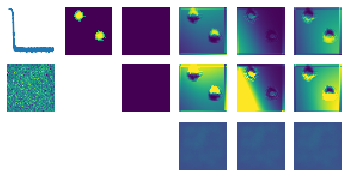

tensor(1.1432e-06) tensor(0.0021) >>><<
tensor(1.1432e-06) tensor(0.0021) >>><<
tensor(1.1432e-06) tensor(0.0021) >>><<


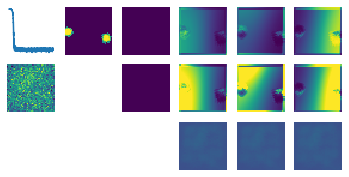

loss 4500 tensor(2.8834, grad_fn=<MseLossBackward0>) 0.00027
tensor(1.2563e-05) tensor(0.0023) >>><<
tensor(1.2563e-05) tensor(0.0023) >>><<
tensor(1.2563e-05) tensor(0.0023) >>><<


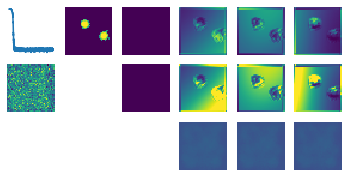

tensor(1.3233e-07) tensor(0.0024) >>><<
tensor(1.3233e-07) tensor(0.0024) >>><<
tensor(1.3233e-07) tensor(0.0024) >>><<


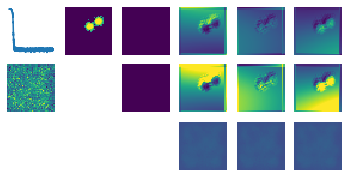

loss 4750 tensor(2.9457, grad_fn=<MseLossBackward0>) 0.000285
tensor(6.6286e-06) tensor(0.0018) >>><<
tensor(6.6286e-06) tensor(0.0018) >>><<
tensor(6.6286e-06) tensor(0.0018) >>><<


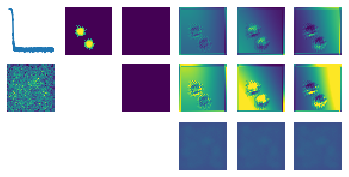

tensor(1.3026e-06) tensor(0.0019) >>><<
tensor(1.3026e-06) tensor(0.0019) >>><<
tensor(1.3026e-06) tensor(0.0019) >>><<


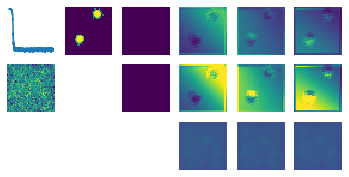

loss 5000 tensor(2.8774, grad_fn=<MseLossBackward0>) 0.0003
tensor(4.6948e-06) tensor(0.0021) >>><<
tensor(4.6948e-06) tensor(0.0021) >>><<
tensor(4.6948e-06) tensor(0.0021) >>><<


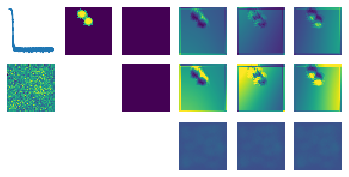

tensor(2.4843e-05) tensor(0.0018) >>><<
tensor(2.4843e-05) tensor(0.0018) >>><<
tensor(2.4843e-05) tensor(0.0018) >>><<


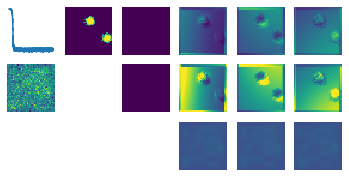

loss 5250 tensor(2.7992, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.2967e-06) tensor(0.0019) >>><<
tensor(1.2967e-06) tensor(0.0019) >>><<
tensor(1.2967e-06) tensor(0.0019) >>><<


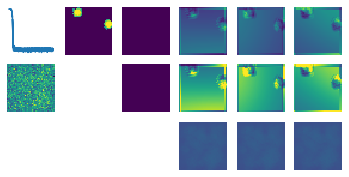

tensor(1.8973e-06) tensor(0.0020) >>><<
tensor(1.8973e-06) tensor(0.0020) >>><<
tensor(1.8973e-06) tensor(0.0020) >>><<


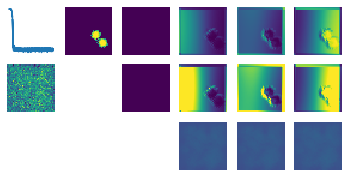

loss 5500 tensor(2.8798, grad_fn=<MseLossBackward0>) 0.0003
tensor(6.0120e-05) tensor(0.0017) >>><<
tensor(6.0120e-05) tensor(0.0017) >>><<
tensor(6.0120e-05) tensor(0.0017) >>><<


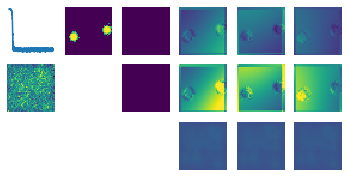

tensor(2.0958e-05) tensor(0.0018) >>><<
tensor(2.0958e-05) tensor(0.0018) >>><<
tensor(2.0958e-05) tensor(0.0018) >>><<


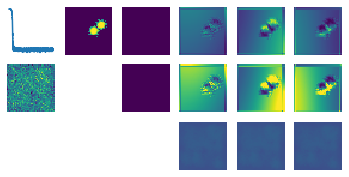

loss 5750 tensor(2.9276, grad_fn=<MseLossBackward0>) 0.0003
tensor(7.6364e-07) tensor(0.0018) >>><<
tensor(7.6364e-07) tensor(0.0018) >>><<
tensor(7.6364e-07) tensor(0.0018) >>><<


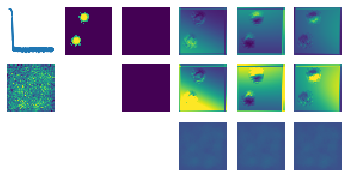

tensor(2.4358e-05) tensor(0.0017) >>><<
tensor(2.4358e-05) tensor(0.0017) >>><<
tensor(2.4358e-05) tensor(0.0017) >>><<


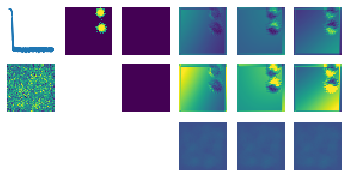

loss 6000 tensor(2.9335, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.6053e-05) tensor(0.0016) >>><<
tensor(1.6053e-05) tensor(0.0016) >>><<
tensor(1.6053e-05) tensor(0.0016) >>><<


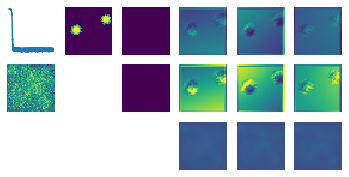

tensor(1.6050e-05) tensor(0.0016) >>><<
tensor(1.6050e-05) tensor(0.0016) >>><<
tensor(1.6050e-05) tensor(0.0016) >>><<


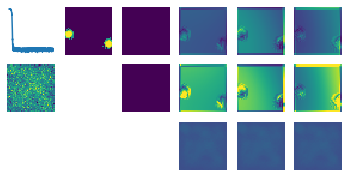

loss 6250 tensor(2.8975, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.2909e-05) tensor(0.0017) >>><<
tensor(1.2909e-05) tensor(0.0017) >>><<
tensor(1.2909e-05) tensor(0.0017) >>><<


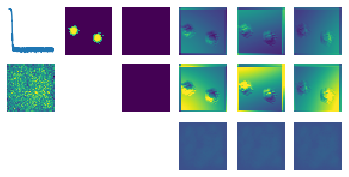

tensor(1.4680e-05) tensor(0.0017) >>><<
tensor(1.4680e-05) tensor(0.0017) >>><<
tensor(1.4680e-05) tensor(0.0017) >>><<


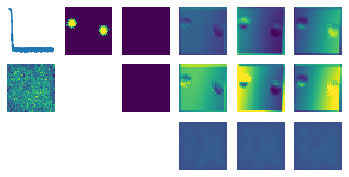

loss 6500 tensor(2.9410, grad_fn=<MseLossBackward0>) 0.0003
tensor(4.4311e-05) tensor(0.0017) >>><<
tensor(4.4311e-05) tensor(0.0017) >>><<
tensor(4.4311e-05) tensor(0.0017) >>><<


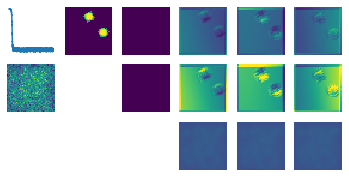

tensor(6.5170e-05) tensor(0.0017) >>><<
tensor(6.5170e-05) tensor(0.0017) >>><<
tensor(6.5170e-05) tensor(0.0017) >>><<


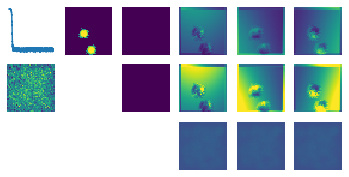

loss 6750 tensor(2.6573, grad_fn=<MseLossBackward0>) 0.0003
tensor(0.0001) tensor(0.0014) >>><<
tensor(0.0001) tensor(0.0014) >>><<
tensor(0.0001) tensor(0.0014) >>><<


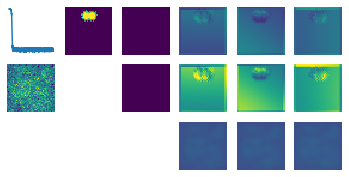

tensor(3.9240e-05) tensor(0.0021) >>><<
tensor(3.9240e-05) tensor(0.0021) >>><<
tensor(3.9240e-05) tensor(0.0021) >>><<


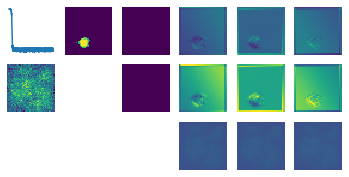

loss 7000 tensor(2.8230, grad_fn=<MseLossBackward0>) 0.0003
tensor(2.4333e-05) tensor(0.0018) >>><<
tensor(2.4333e-05) tensor(0.0018) >>><<
tensor(2.4333e-05) tensor(0.0018) >>><<


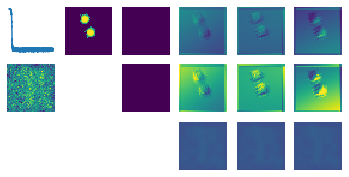

tensor(3.8598e-05) tensor(0.0015) >>><<
tensor(3.8598e-05) tensor(0.0015) >>><<
tensor(3.8598e-05) tensor(0.0015) >>><<


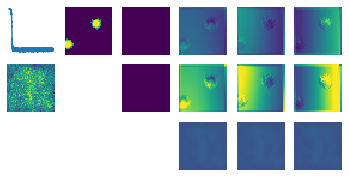

loss 7250 tensor(2.8171, grad_fn=<MseLossBackward0>) 0.0003
tensor(6.8567e-05) tensor(0.0017) >>><<
tensor(6.8567e-05) tensor(0.0017) >>><<
tensor(6.8567e-05) tensor(0.0017) >>><<


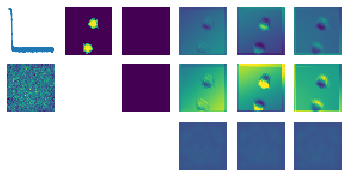

tensor(6.7943e-05) tensor(0.0016) >>><<
tensor(6.7943e-05) tensor(0.0016) >>><<
tensor(6.7943e-05) tensor(0.0016) >>><<


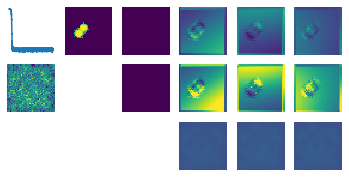

loss 7500 tensor(2.8799, grad_fn=<MseLossBackward0>) 0.0003
tensor(6.8398e-05) tensor(0.0015) >>><<
tensor(6.8398e-05) tensor(0.0015) >>><<
tensor(6.8398e-05) tensor(0.0015) >>><<


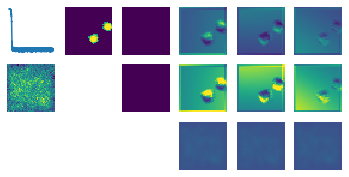

tensor(0.0001) tensor(0.0015) >>><<
tensor(0.0001) tensor(0.0015) >>><<
tensor(0.0001) tensor(0.0015) >>><<


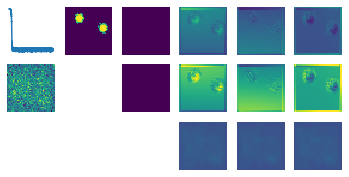

loss 7750 tensor(2.9373, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.4055e-05) tensor(0.0018) >>><<
tensor(1.4055e-05) tensor(0.0018) >>><<
tensor(1.4055e-05) tensor(0.0018) >>><<


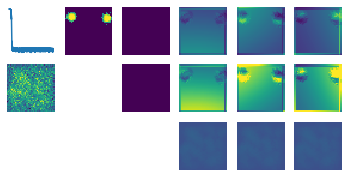

tensor(3.3410e-05) tensor(0.0017) >>><<
tensor(3.3410e-05) tensor(0.0017) >>><<
tensor(3.3410e-05) tensor(0.0017) >>><<


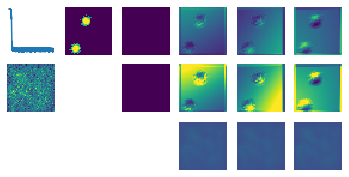

loss 8000 tensor(2.9045, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.9828e-05) tensor(0.0017) >>><<
tensor(1.9828e-05) tensor(0.0017) >>><<
tensor(1.9828e-05) tensor(0.0017) >>><<


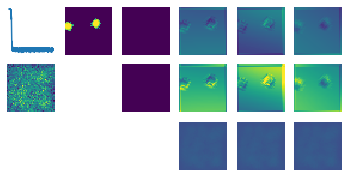

tensor(0.0001) tensor(0.0017) >>><<
tensor(0.0001) tensor(0.0017) >>><<
tensor(0.0001) tensor(0.0017) >>><<


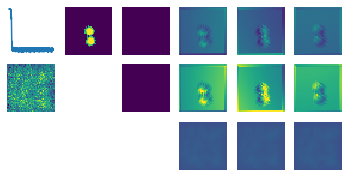

loss 8250 tensor(2.9907, grad_fn=<MseLossBackward0>) 0.0003
tensor(2.9055e-05) tensor(0.0016) >>><<
tensor(2.9055e-05) tensor(0.0016) >>><<
tensor(2.9055e-05) tensor(0.0016) >>><<


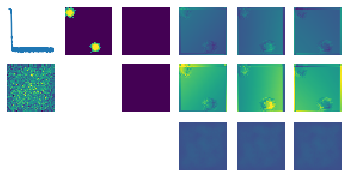

tensor(4.4357e-05) tensor(0.0018) >>><<
tensor(4.4357e-05) tensor(0.0018) >>><<
tensor(4.4357e-05) tensor(0.0018) >>><<


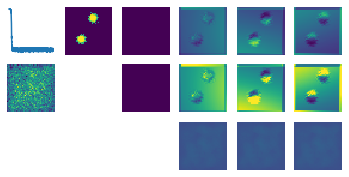

loss 8500 tensor(2.9764, grad_fn=<MseLossBackward0>) 0.0003
tensor(9.0274e-05) tensor(0.0016) >>><<
tensor(9.0274e-05) tensor(0.0016) >>><<
tensor(9.0274e-05) tensor(0.0016) >>><<


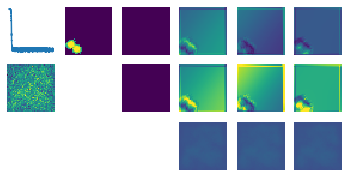

tensor(8.0266e-05) tensor(0.0016) >>><<
tensor(8.0266e-05) tensor(0.0016) >>><<
tensor(8.0266e-05) tensor(0.0016) >>><<


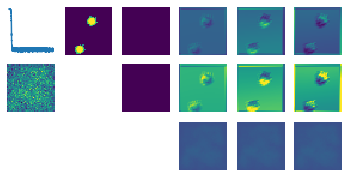

loss 8750 tensor(2.8312, grad_fn=<MseLossBackward0>) 0.0003
tensor(2.2227e-05) tensor(0.0016) >>><<
tensor(2.2227e-05) tensor(0.0016) >>><<
tensor(2.2227e-05) tensor(0.0016) >>><<


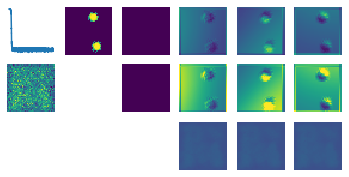

tensor(3.9315e-05) tensor(0.0018) >>><<
tensor(3.9315e-05) tensor(0.0018) >>><<
tensor(3.9315e-05) tensor(0.0018) >>><<


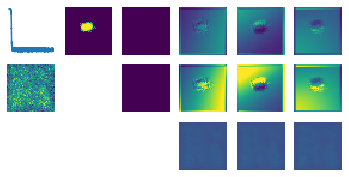

loss 9000 tensor(2.8871, grad_fn=<MseLossBackward0>) 0.0003
tensor(2.9398e-05) tensor(0.0015) >>><<
tensor(2.9398e-05) tensor(0.0015) >>><<
tensor(2.9398e-05) tensor(0.0015) >>><<


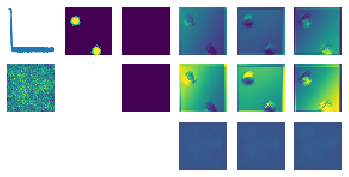

tensor(0.0001) tensor(0.0012) >>><<
tensor(0.0001) tensor(0.0012) >>><<
tensor(0.0001) tensor(0.0012) >>><<


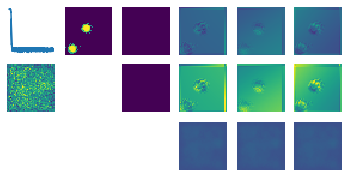

loss 9250 tensor(2.8975, grad_fn=<MseLossBackward0>) 0.0003
tensor(2.0932e-05) tensor(0.0014) >>><<
tensor(2.0932e-05) tensor(0.0014) >>><<
tensor(2.0932e-05) tensor(0.0014) >>><<


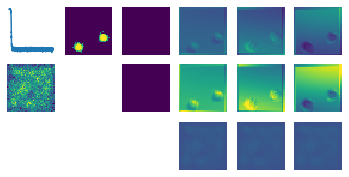

tensor(4.1546e-06) tensor(0.0016) >>><<
tensor(4.1546e-06) tensor(0.0016) >>><<
tensor(4.1546e-06) tensor(0.0016) >>><<


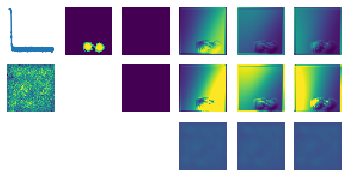

loss 9500 tensor(2.8232, grad_fn=<MseLossBackward0>) 0.0003
tensor(0.0001) tensor(0.0013) >>><<
tensor(0.0001) tensor(0.0013) >>><<
tensor(0.0001) tensor(0.0013) >>><<


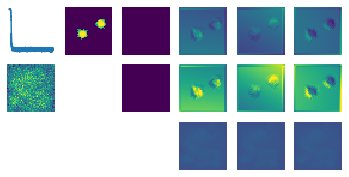

tensor(3.9937e-05) tensor(0.0017) >>><<
tensor(3.9937e-05) tensor(0.0017) >>><<
tensor(3.9937e-05) tensor(0.0017) >>><<


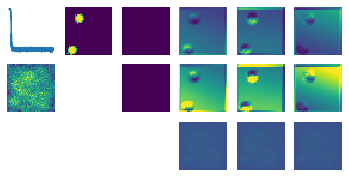

loss 9750 tensor(2.9188, grad_fn=<MseLossBackward0>) 0.0003
tensor(4.7840e-05) tensor(0.0015) >>><<
tensor(4.7840e-05) tensor(0.0015) >>><<
tensor(4.7840e-05) tensor(0.0015) >>><<


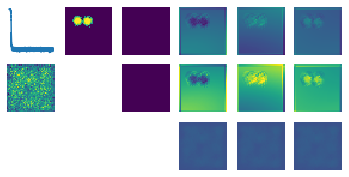

tensor(7.0846e-05) tensor(0.0017) >>><<
tensor(7.0846e-05) tensor(0.0017) >>><<
tensor(7.0846e-05) tensor(0.0017) >>><<


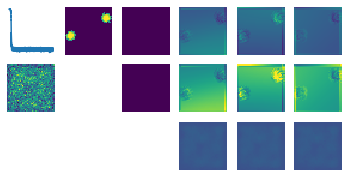

loss 10000 tensor(3.0014, grad_fn=<MseLossBackward0>) 0.0003
tensor(7.2557e-06) tensor(0.0016) >>><<
tensor(7.2557e-06) tensor(0.0016) >>><<
tensor(7.2557e-06) tensor(0.0016) >>><<


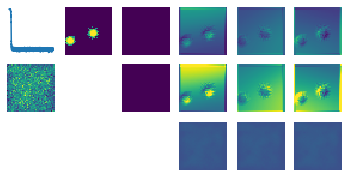

tensor(6.9025e-05) tensor(0.0015) >>><<
tensor(6.9025e-05) tensor(0.0015) >>><<
tensor(6.9025e-05) tensor(0.0015) >>><<


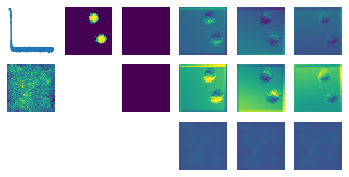

loss 10250 tensor(3.0110, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.2092e-05) tensor(0.0022) >>><<
tensor(1.2092e-05) tensor(0.0022) >>><<
tensor(1.2092e-05) tensor(0.0022) >>><<


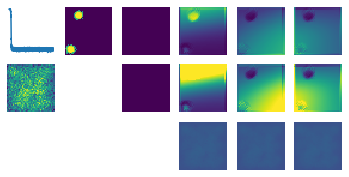

tensor(7.0419e-06) tensor(0.0021) >>><<
tensor(7.0419e-06) tensor(0.0021) >>><<
tensor(7.0419e-06) tensor(0.0021) >>><<


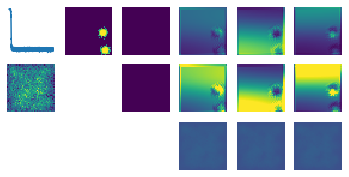

loss 10500 tensor(2.7763, grad_fn=<MseLossBackward0>) 0.0003
tensor(2.0873e-08) tensor(0.0056) >>><<
tensor(2.0873e-08) tensor(0.0056) >>><<
tensor(2.0873e-08) tensor(0.0056) >>><<


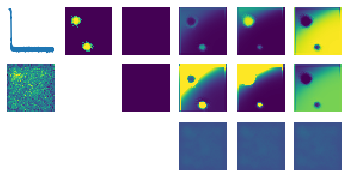

tensor(1.4284e-08) tensor(0.0046) >>><<
tensor(1.4284e-08) tensor(0.0046) >>><<
tensor(1.4284e-08) tensor(0.0046) >>><<


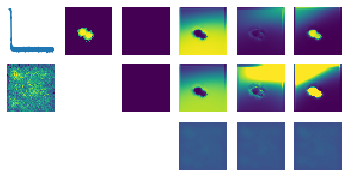

loss 10750 tensor(2.5169, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0420) >>><<
tensor(1.0000e-08) tensor(0.0420) >>><<
tensor(1.0000e-08) tensor(0.0420) >>><<


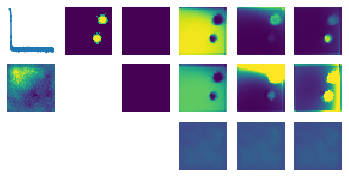

tensor(1.0000e-08) tensor(0.0391) >>><<
tensor(1.0000e-08) tensor(0.0391) >>><<
tensor(1.0000e-08) tensor(0.0391) >>><<


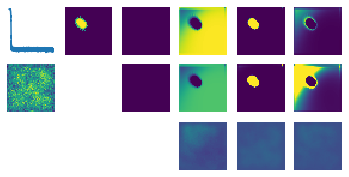

loss 11000 tensor(2.8913, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4185) >>><<
tensor(1.0000e-08) tensor(0.4185) >>><<
tensor(1.0000e-08) tensor(0.4185) >>><<


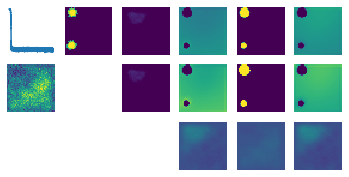

tensor(1.0000e-08) tensor(0.1593) >>><<
tensor(1.0000e-08) tensor(0.1593) >>><<
tensor(1.0000e-08) tensor(0.1593) >>><<


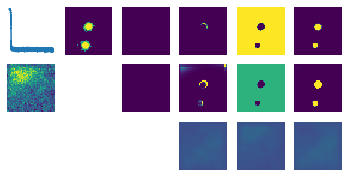

loss 11250 tensor(2.8679, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2094) >>><<
tensor(1.0000e-08) tensor(0.2094) >>><<
tensor(1.0000e-08) tensor(0.2094) >>><<


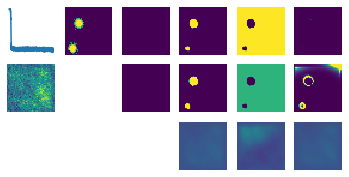

tensor(1.0000e-08) tensor(0.1033) >>><<
tensor(1.0000e-08) tensor(0.1033) >>><<
tensor(1.0000e-08) tensor(0.1033) >>><<


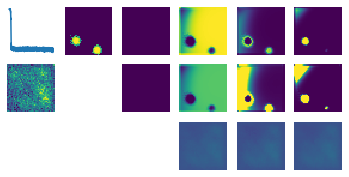

loss 11500 tensor(2.7577, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1688) >>><<
tensor(1.0000e-08) tensor(0.1688) >>><<
tensor(1.0000e-08) tensor(0.1688) >>><<


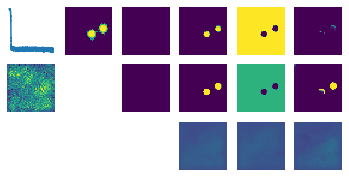

tensor(1.0000e-08) tensor(0.1534) >>><<
tensor(1.0000e-08) tensor(0.1534) >>><<
tensor(1.0000e-08) tensor(0.1534) >>><<


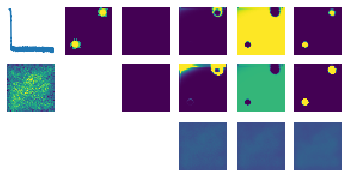

loss 11750 tensor(2.6854, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2689) >>><<
tensor(1.0000e-08) tensor(0.2689) >>><<
tensor(1.0000e-08) tensor(0.2689) >>><<


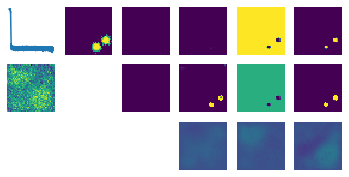

tensor(1.0000e-08) tensor(0.0739) >>><<
tensor(1.0000e-08) tensor(0.0739) >>><<
tensor(1.0000e-08) tensor(0.0739) >>><<


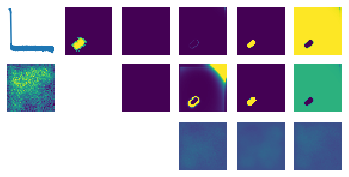

loss 12000 tensor(2.5580, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0807) >>><<
tensor(1.0000e-08) tensor(0.0807) >>><<
tensor(1.0000e-08) tensor(0.0807) >>><<


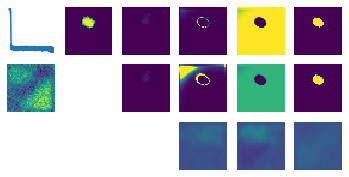

tensor(1.0000e-08) tensor(0.1150) >>><<
tensor(1.0000e-08) tensor(0.1150) >>><<
tensor(1.0000e-08) tensor(0.1150) >>><<


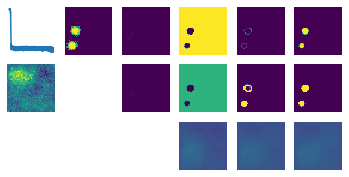

loss 12250 tensor(2.5756, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1686) >>><<
tensor(1.0000e-08) tensor(0.1686) >>><<
tensor(1.0000e-08) tensor(0.1686) >>><<


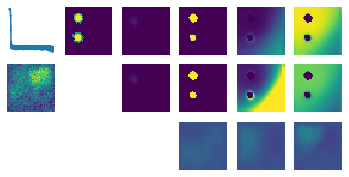

tensor(1.0000e-08) tensor(0.0872) >>><<
tensor(1.0000e-08) tensor(0.0872) >>><<
tensor(1.0000e-08) tensor(0.0872) >>><<


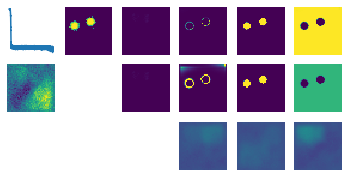

loss 12500 tensor(2.6279, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1675) >>><<
tensor(1.0000e-08) tensor(0.1675) >>><<
tensor(1.0000e-08) tensor(0.1675) >>><<


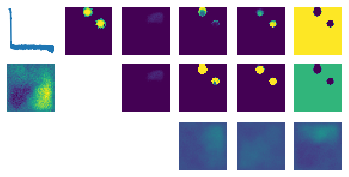

tensor(1.0000e-08) tensor(0.0886) >>><<
tensor(1.0000e-08) tensor(0.0886) >>><<
tensor(1.0000e-08) tensor(0.0886) >>><<


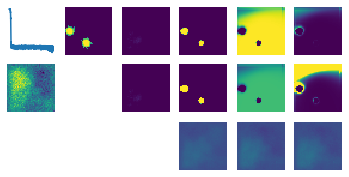

loss 12750 tensor(2.5189, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1811) >>><<
tensor(1.0000e-08) tensor(0.1811) >>><<
tensor(1.0000e-08) tensor(0.1811) >>><<


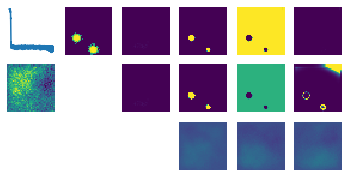

tensor(1.0000e-08) tensor(0.1531) >>><<
tensor(1.0000e-08) tensor(0.1531) >>><<
tensor(1.0000e-08) tensor(0.1531) >>><<


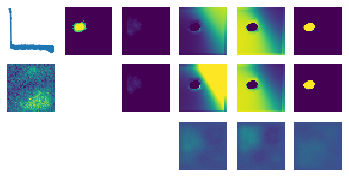

loss 13000 tensor(2.5816, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1477) >>><<
tensor(1.0000e-08) tensor(0.1477) >>><<
tensor(1.0000e-08) tensor(0.1477) >>><<


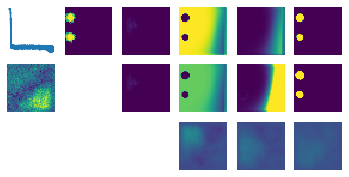

tensor(1.0000e-08) tensor(0.0397) >>><<
tensor(1.0000e-08) tensor(0.0397) >>><<
tensor(1.0000e-08) tensor(0.0397) >>><<


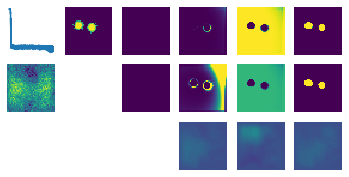

loss 13250 tensor(2.2215, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1082) >>><<
tensor(1.0000e-08) tensor(0.1082) >>><<
tensor(1.0000e-08) tensor(0.1082) >>><<


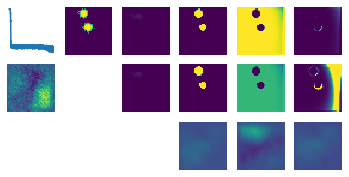

tensor(1.0000e-08) tensor(0.0485) >>><<
tensor(1.0000e-08) tensor(0.0485) >>><<
tensor(1.0000e-08) tensor(0.0485) >>><<


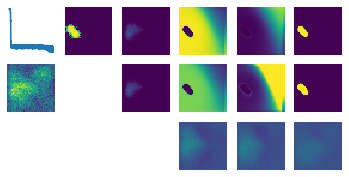

loss 13500 tensor(2.4245, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1046) >>><<
tensor(1.0000e-08) tensor(0.1046) >>><<
tensor(1.0000e-08) tensor(0.1046) >>><<


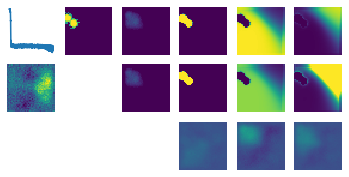

tensor(1.0000e-08) tensor(0.0821) >>><<
tensor(1.0000e-08) tensor(0.0821) >>><<
tensor(1.0000e-08) tensor(0.0821) >>><<


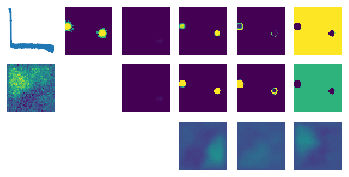

loss 13750 tensor(2.6558, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4640) >>><<
tensor(1.0000e-08) tensor(0.4640) >>><<
tensor(1.0000e-08) tensor(0.4640) >>><<


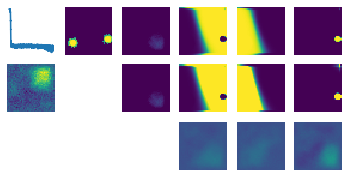

tensor(1.0000e-08) tensor(0.4684) >>><<
tensor(1.0000e-08) tensor(0.4684) >>><<
tensor(1.0000e-08) tensor(0.4684) >>><<


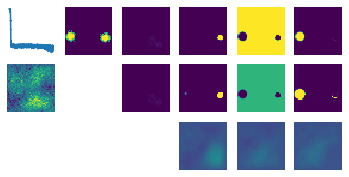

loss 14000 tensor(2.5128, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1778) >>><<
tensor(1.0000e-08) tensor(0.1778) >>><<
tensor(1.0000e-08) tensor(0.1778) >>><<


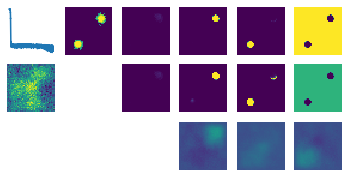

tensor(1.0000e-08) tensor(0.0601) >>><<
tensor(1.0000e-08) tensor(0.0601) >>><<
tensor(1.0000e-08) tensor(0.0601) >>><<


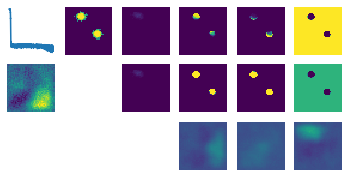

loss 14250 tensor(2.6085, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0697) >>><<
tensor(1.0000e-08) tensor(0.0697) >>><<
tensor(1.0000e-08) tensor(0.0697) >>><<


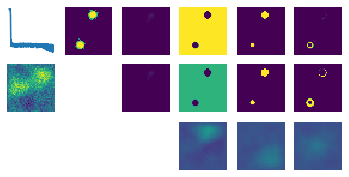

tensor(1.0000e-08) tensor(0.0604) >>><<
tensor(1.0000e-08) tensor(0.0604) >>><<
tensor(1.0000e-08) tensor(0.0604) >>><<


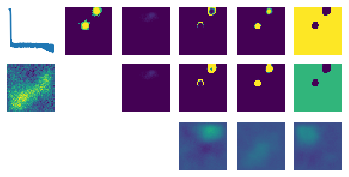

loss 14500 tensor(2.3006, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4553) >>><<
tensor(1.0000e-08) tensor(0.4553) >>><<
tensor(1.0000e-08) tensor(0.4553) >>><<


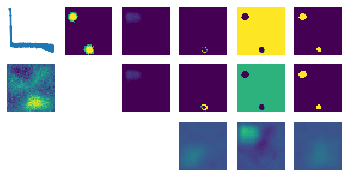

tensor(1.0000e-08) tensor(0.4552) >>><<
tensor(1.0000e-08) tensor(0.4552) >>><<
tensor(1.0000e-08) tensor(0.4552) >>><<


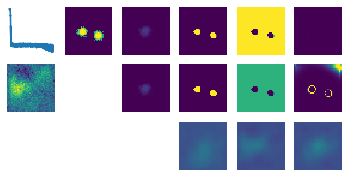

loss 14750 tensor(2.2173, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1290) >>><<
tensor(1.0000e-08) tensor(0.1290) >>><<
tensor(1.0000e-08) tensor(0.1290) >>><<


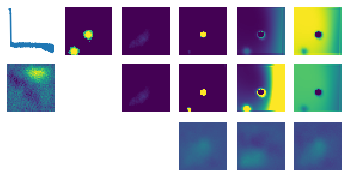

tensor(1.0000e-08) tensor(0.1419) >>><<
tensor(1.0000e-08) tensor(0.1419) >>><<
tensor(1.0000e-08) tensor(0.1419) >>><<


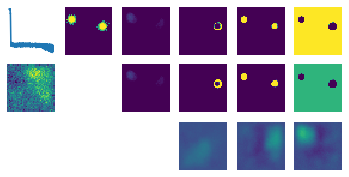

loss 15000 tensor(2.6250, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1154) >>><<
tensor(1.0000e-08) tensor(0.1154) >>><<
tensor(1.0000e-08) tensor(0.1154) >>><<


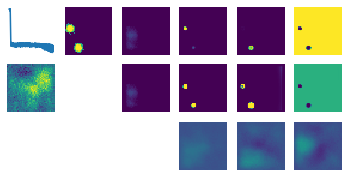

tensor(1.0000e-08) tensor(0.0920) >>><<
tensor(1.0000e-08) tensor(0.0920) >>><<
tensor(1.0000e-08) tensor(0.0920) >>><<


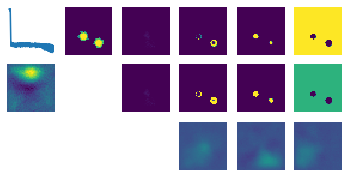

loss 15250 tensor(2.2129, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0778) >>><<
tensor(1.0000e-08) tensor(0.0778) >>><<
tensor(1.0000e-08) tensor(0.0778) >>><<


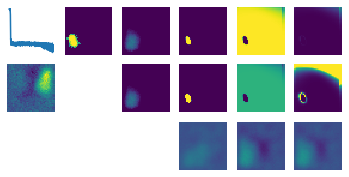

tensor(1.0000e-08) tensor(0.2201) >>><<
tensor(1.0000e-08) tensor(0.2201) >>><<
tensor(1.0000e-08) tensor(0.2201) >>><<


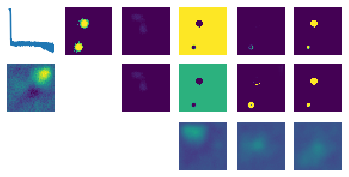

loss 15500 tensor(2.6867, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1234) >>><<
tensor(1.0000e-08) tensor(0.1234) >>><<
tensor(1.0000e-08) tensor(0.1234) >>><<


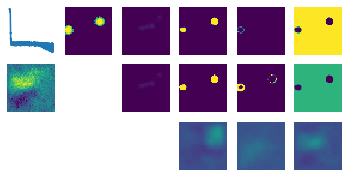

tensor(1.0000e-08) tensor(0.3063) >>><<
tensor(1.0000e-08) tensor(0.3063) >>><<
tensor(1.0000e-08) tensor(0.3063) >>><<


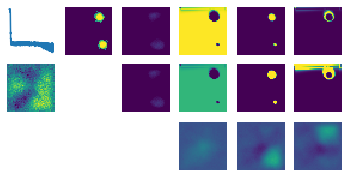

loss 15750 tensor(2.3587, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0622) >>><<
tensor(1.0000e-08) tensor(0.0622) >>><<
tensor(1.0000e-08) tensor(0.0622) >>><<


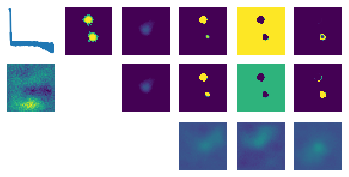

tensor(1.0000e-08) tensor(0.1157) >>><<
tensor(1.0000e-08) tensor(0.1157) >>><<
tensor(1.0000e-08) tensor(0.1157) >>><<


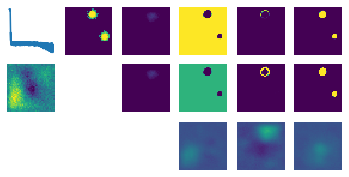

loss 16000 tensor(2.5942, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2974) >>><<
tensor(1.0000e-08) tensor(0.2974) >>><<
tensor(1.0000e-08) tensor(0.2974) >>><<
tensor(1.0000e-08) tensor(0.2501) >>><<
tensor(1.0000e-08) tensor(0.2501) >>><<
tensor(1.0000e-08) tensor(0.2501) >>><<


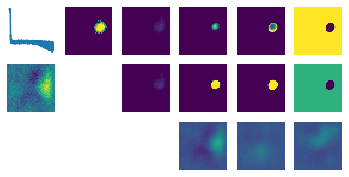

tensor(1.0000e-08) tensor(0.3429) >>><<
tensor(1.0000e-08) tensor(0.3429) >>><<
tensor(1.0000e-08) tensor(0.3429) >>><<


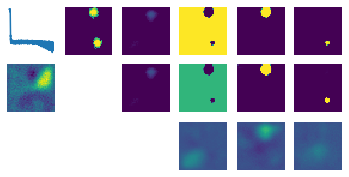

loss 17000 tensor(2.1515, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1293) >>><<
tensor(1.0000e-08) tensor(0.1293) >>><<
tensor(1.0000e-08) tensor(0.1293) >>><<


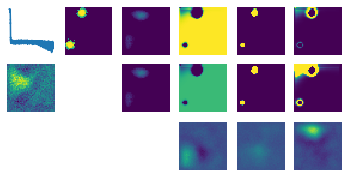

tensor(1.0000e-08) tensor(0.0691) >>><<
tensor(1.0000e-08) tensor(0.0691) >>><<
tensor(1.0000e-08) tensor(0.0691) >>><<


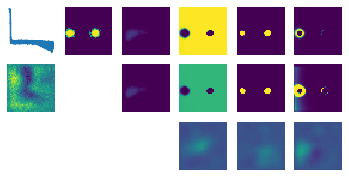

loss 17250 tensor(1.9749, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1028) >>><<
tensor(1.0000e-08) tensor(0.1028) >>><<
tensor(1.0000e-08) tensor(0.1028) >>><<


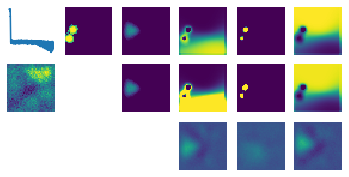

tensor(1.0000e-08) tensor(0.0446) >>><<
tensor(1.0000e-08) tensor(0.0446) >>><<
tensor(1.0000e-08) tensor(0.0446) >>><<


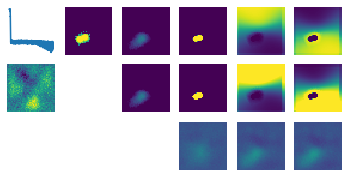

loss 17500 tensor(2.4267, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1242) >>><<
tensor(1.0000e-08) tensor(0.1242) >>><<
tensor(1.0000e-08) tensor(0.1242) >>><<


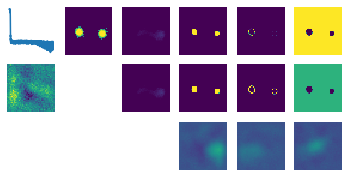

tensor(1.0000e-08) tensor(0.0966) >>><<
tensor(1.0000e-08) tensor(0.0966) >>><<
tensor(1.0000e-08) tensor(0.0966) >>><<


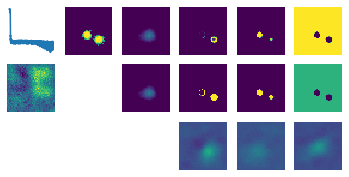

loss 17750 tensor(2.0261, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5184) >>><<
tensor(1.0000e-08) tensor(0.5184) >>><<
tensor(1.0000e-08) tensor(0.5184) >>><<


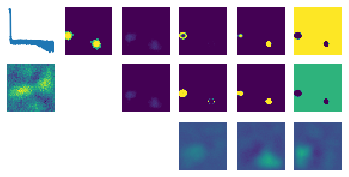

tensor(1.0000e-08) tensor(0.3489) >>><<
tensor(1.0000e-08) tensor(0.3489) >>><<
tensor(1.0000e-08) tensor(0.3489) >>><<


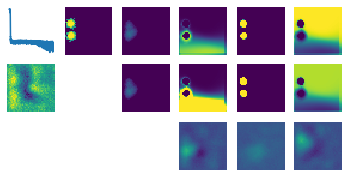

loss 18000 tensor(2.2158, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1576) >>><<
tensor(1.0000e-08) tensor(0.1576) >>><<
tensor(1.0000e-08) tensor(0.1576) >>><<


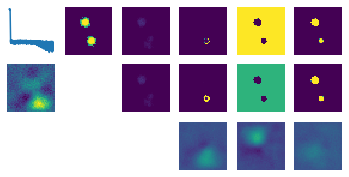

tensor(1.0000e-08) tensor(0.0519) >>><<
tensor(1.0000e-08) tensor(0.0519) >>><<
tensor(1.0000e-08) tensor(0.0519) >>><<


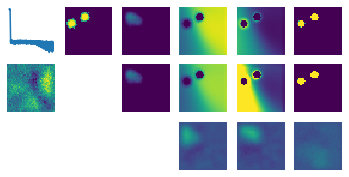

loss 18250 tensor(1.9250, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1010) >>><<
tensor(1.0000e-08) tensor(0.1010) >>><<
tensor(1.0000e-08) tensor(0.1010) >>><<


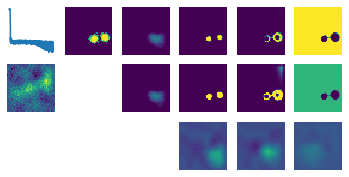

tensor(1.0000e-08) tensor(0.0653) >>><<
tensor(1.0000e-08) tensor(0.0653) >>><<
tensor(1.0000e-08) tensor(0.0653) >>><<


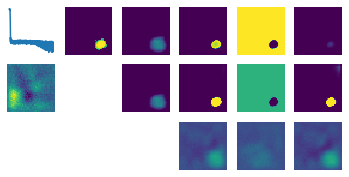

loss 18500 tensor(2.1693, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3128) >>><<
tensor(1.0000e-08) tensor(0.3128) >>><<
tensor(1.0000e-08) tensor(0.3128) >>><<


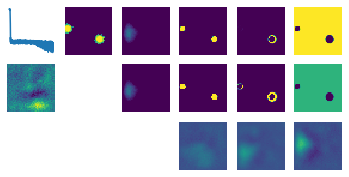

tensor(1.0000e-08) tensor(0.1409) >>><<
tensor(1.0000e-08) tensor(0.1409) >>><<
tensor(1.0000e-08) tensor(0.1409) >>><<


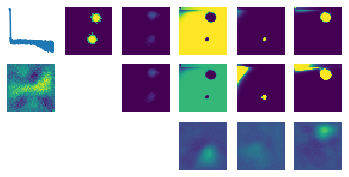

loss 18750 tensor(2.3757, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0810) >>><<
tensor(1.0000e-08) tensor(0.0810) >>><<
tensor(1.0000e-08) tensor(0.0810) >>><<


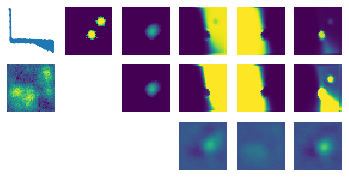

tensor(1.0000e-08) tensor(0.1390) >>><<
tensor(1.0000e-08) tensor(0.1390) >>><<
tensor(1.0000e-08) tensor(0.1390) >>><<


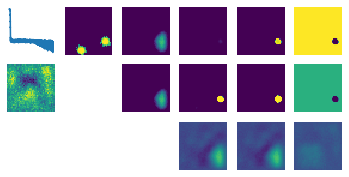

loss 19000 tensor(2.1109, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0792) >>><<
tensor(1.0000e-08) tensor(0.0792) >>><<
tensor(1.0000e-08) tensor(0.0792) >>><<


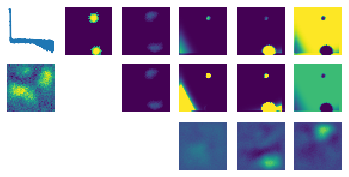

tensor(1.0000e-08) tensor(0.1285) >>><<
tensor(1.0000e-08) tensor(0.1285) >>><<
tensor(1.0000e-08) tensor(0.1285) >>><<


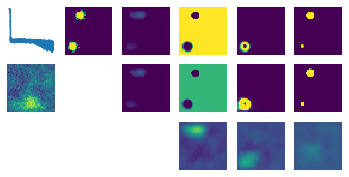

loss 19250 tensor(1.9368, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0693) >>><<
tensor(1.0000e-08) tensor(0.0693) >>><<
tensor(1.0000e-08) tensor(0.0693) >>><<


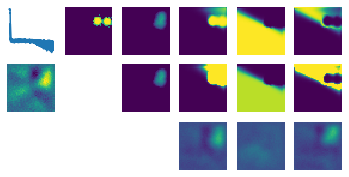

tensor(1.0000e-08) tensor(0.1043) >>><<
tensor(1.0000e-08) tensor(0.1043) >>><<
tensor(1.0000e-08) tensor(0.1043) >>><<


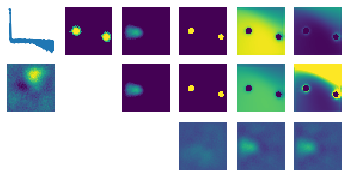

loss 19500 tensor(2.2768, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2754) >>><<
tensor(1.0000e-08) tensor(0.2754) >>><<
tensor(1.0000e-08) tensor(0.2754) >>><<


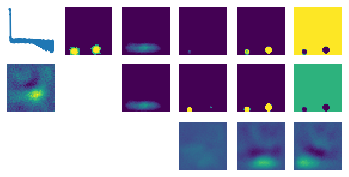

tensor(1.0000e-08) tensor(0.4709) >>><<
tensor(1.0000e-08) tensor(0.4709) >>><<
tensor(1.0000e-08) tensor(0.4709) >>><<


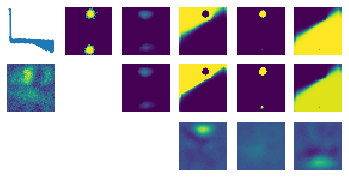

loss 19750 tensor(1.6242, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5266) >>><<
tensor(1.0000e-08) tensor(0.5266) >>><<
tensor(1.0000e-08) tensor(0.5266) >>><<


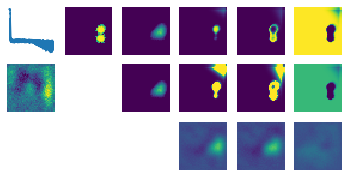

tensor(1.0000e-08) tensor(0.1026) >>><<
tensor(1.0000e-08) tensor(0.1026) >>><<
tensor(1.0000e-08) tensor(0.1026) >>><<


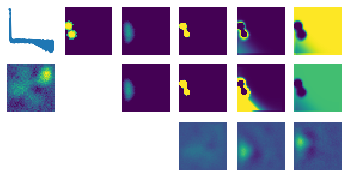

loss 20000 tensor(2.0991, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4344) >>><<
tensor(1.0000e-08) tensor(0.4344) >>><<
tensor(1.0000e-08) tensor(0.4344) >>><<


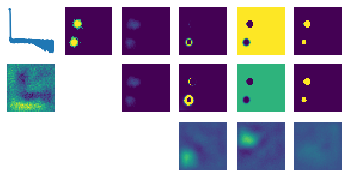

tensor(1.0000e-08) tensor(0.0521) >>><<
tensor(1.0000e-08) tensor(0.0521) >>><<
tensor(1.0000e-08) tensor(0.0521) >>><<


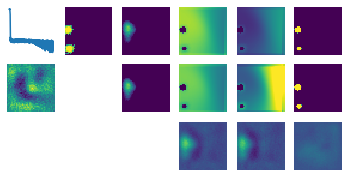

loss 20250 tensor(2.4625, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2482) >>><<
tensor(1.0000e-08) tensor(0.2482) >>><<
tensor(1.0000e-08) tensor(0.2482) >>><<


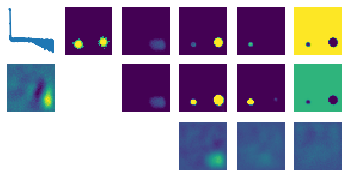

tensor(1.0000e-08) tensor(0.2168) >>><<
tensor(1.0000e-08) tensor(0.2168) >>><<
tensor(1.0000e-08) tensor(0.2168) >>><<


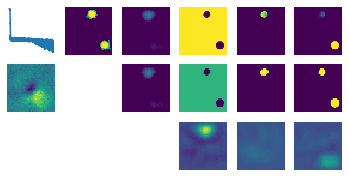

loss 20500 tensor(1.8865, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1968) >>><<
tensor(1.0000e-08) tensor(0.1968) >>><<
tensor(1.0000e-08) tensor(0.1968) >>><<


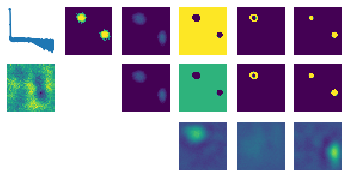

tensor(1.0000e-08) tensor(0.1461) >>><<
tensor(1.0000e-08) tensor(0.1461) >>><<
tensor(1.0000e-08) tensor(0.1461) >>><<


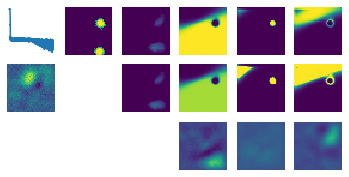

loss 20750 tensor(1.8325, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1789) >>><<
tensor(1.0000e-08) tensor(0.1789) >>><<
tensor(1.0000e-08) tensor(0.1789) >>><<


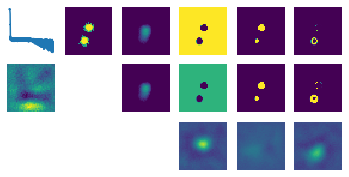

tensor(1.0000e-08) tensor(0.2043) >>><<
tensor(1.0000e-08) tensor(0.2043) >>><<
tensor(1.0000e-08) tensor(0.2043) >>><<


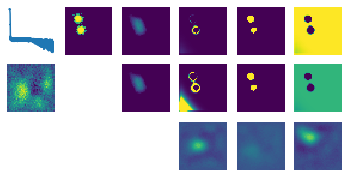

loss 21000 tensor(1.4351, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4763) >>><<
tensor(1.0000e-08) tensor(0.4763) >>><<
tensor(1.0000e-08) tensor(0.4763) >>><<


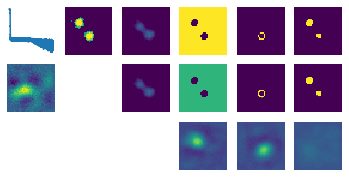

tensor(1.0000e-08) tensor(0.7261) >>><<
tensor(1.0000e-08) tensor(0.7261) >>><<
tensor(1.0000e-08) tensor(0.7261) >>><<


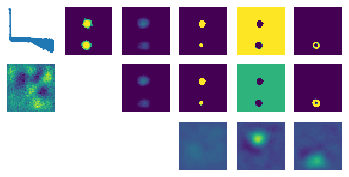

loss 21250 tensor(1.6566, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1006) >>><<
tensor(1.0000e-08) tensor(0.1006) >>><<
tensor(1.0000e-08) tensor(0.1006) >>><<


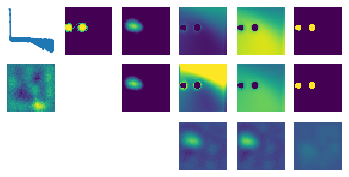

tensor(1.0000e-08) tensor(0.0646) >>><<
tensor(1.0000e-08) tensor(0.0646) >>><<
tensor(1.0000e-08) tensor(0.0646) >>><<


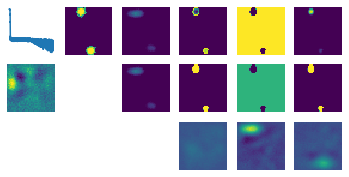

loss 21500 tensor(1.9041, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2068) >>><<
tensor(1.0000e-08) tensor(0.2068) >>><<
tensor(1.0000e-08) tensor(0.2068) >>><<


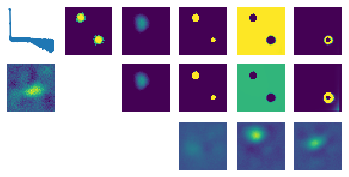

tensor(1.0000e-08) tensor(0.1060) >>><<
tensor(1.0000e-08) tensor(0.1060) >>><<
tensor(1.0000e-08) tensor(0.1060) >>><<


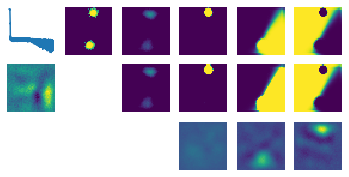

loss 21750 tensor(1.7440, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2440) >>><<
tensor(1.0000e-08) tensor(0.2440) >>><<
tensor(1.0000e-08) tensor(0.2440) >>><<


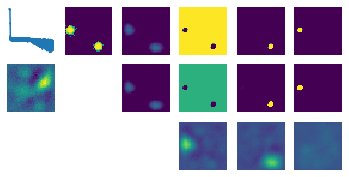

tensor(1.0000e-08) tensor(0.1024) >>><<
tensor(1.0000e-08) tensor(0.1024) >>><<
tensor(1.0000e-08) tensor(0.1024) >>><<


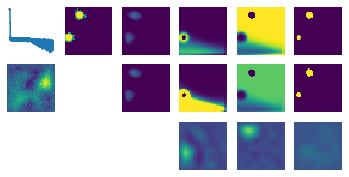

loss 22000 tensor(2.0944, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1322) >>><<
tensor(1.0000e-08) tensor(0.1322) >>><<
tensor(1.0000e-08) tensor(0.1322) >>><<


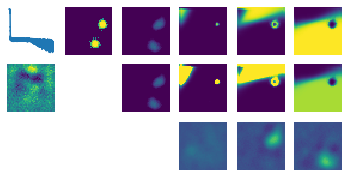

tensor(1.0000e-08) tensor(0.1018) >>><<
tensor(1.0000e-08) tensor(0.1018) >>><<
tensor(1.0000e-08) tensor(0.1018) >>><<


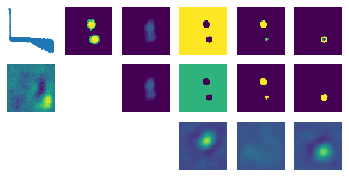

loss 22250 tensor(2.0492, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0932) >>><<
tensor(1.0000e-08) tensor(0.0932) >>><<
tensor(1.0000e-08) tensor(0.0932) >>><<


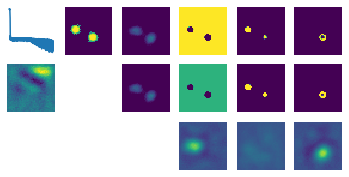

tensor(1.0000e-08) tensor(0.0851) >>><<
tensor(1.0000e-08) tensor(0.0851) >>><<
tensor(1.0000e-08) tensor(0.0851) >>><<


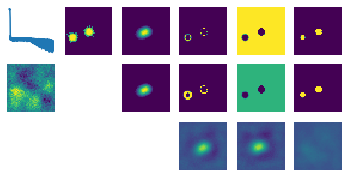

loss 22500 tensor(2.1597, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1959) >>><<
tensor(1.0000e-08) tensor(0.1959) >>><<
tensor(1.0000e-08) tensor(0.1959) >>><<


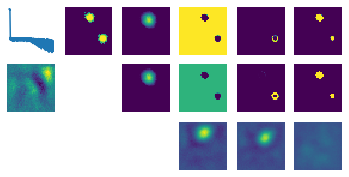

tensor(1.0000e-08) tensor(0.1350) >>><<
tensor(1.0000e-08) tensor(0.1350) >>><<
tensor(1.0000e-08) tensor(0.1350) >>><<


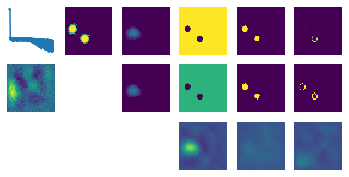

loss 22750 tensor(1.7324, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1336) >>><<
tensor(1.0000e-08) tensor(0.1336) >>><<
tensor(1.0000e-08) tensor(0.1336) >>><<


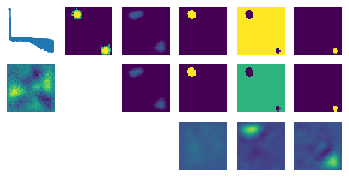

tensor(1.0000e-08) tensor(0.1085) >>><<
tensor(1.0000e-08) tensor(0.1085) >>><<
tensor(1.0000e-08) tensor(0.1085) >>><<


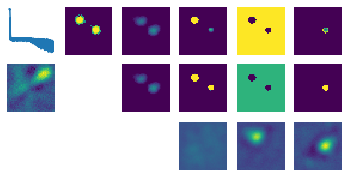

loss 23000 tensor(1.7564, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0813) >>><<
tensor(1.0000e-08) tensor(0.0813) >>><<
tensor(1.0000e-08) tensor(0.0813) >>><<


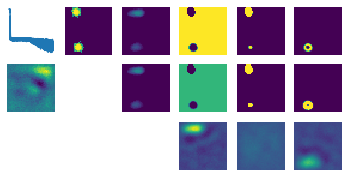

tensor(1.0000e-08) tensor(0.4124) >>><<
tensor(1.0000e-08) tensor(0.4124) >>><<
tensor(1.0000e-08) tensor(0.4124) >>><<


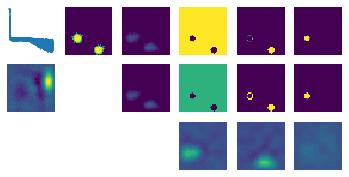

loss 23250 tensor(1.8380, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2562) >>><<
tensor(1.0000e-08) tensor(0.2562) >>><<
tensor(1.0000e-08) tensor(0.2562) >>><<


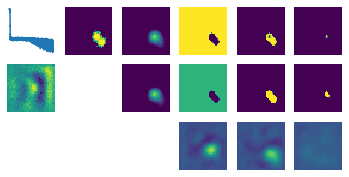

tensor(1.0000e-08) tensor(0.1412) >>><<
tensor(1.0000e-08) tensor(0.1412) >>><<
tensor(1.0000e-08) tensor(0.1412) >>><<


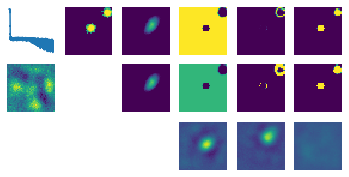

loss 23500 tensor(2.6217, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1848) >>><<
tensor(1.0000e-08) tensor(0.1848) >>><<
tensor(1.0000e-08) tensor(0.1848) >>><<


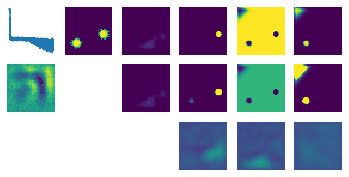

tensor(1.0000e-08) tensor(0.3248) >>><<
tensor(1.0000e-08) tensor(0.3248) >>><<
tensor(1.0000e-08) tensor(0.3248) >>><<


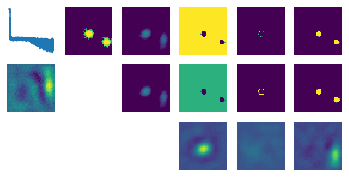

loss 23750 tensor(1.5192, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1795) >>><<
tensor(1.0000e-08) tensor(0.1795) >>><<
tensor(1.0000e-08) tensor(0.1795) >>><<


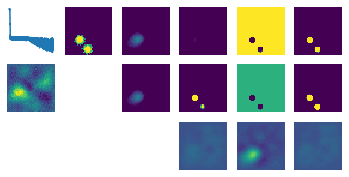

tensor(1.0000e-08) tensor(0.1332) >>><<
tensor(1.0000e-08) tensor(0.1332) >>><<
tensor(1.0000e-08) tensor(0.1332) >>><<


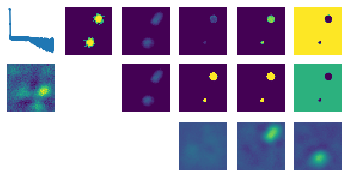

loss 24000 tensor(1.4328, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0962) >>><<
tensor(1.0000e-08) tensor(0.0962) >>><<
tensor(1.0000e-08) tensor(0.0962) >>><<


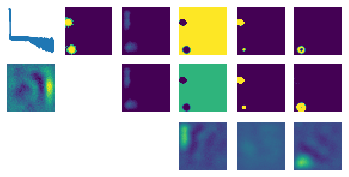

tensor(1.0000e-08) tensor(0.1995) >>><<
tensor(1.0000e-08) tensor(0.1995) >>><<
tensor(1.0000e-08) tensor(0.1995) >>><<


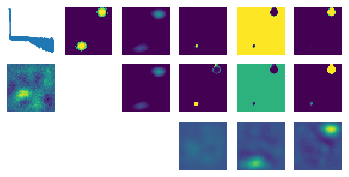

loss 24250 tensor(1.1040, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1343) >>><<
tensor(1.0000e-08) tensor(0.1343) >>><<
tensor(1.0000e-08) tensor(0.1343) >>><<


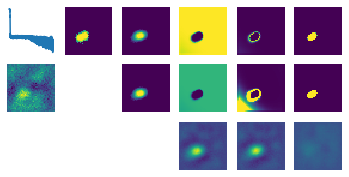

tensor(1.0000e-08) tensor(0.1900) >>><<
tensor(1.0000e-08) tensor(0.1900) >>><<
tensor(1.0000e-08) tensor(0.1900) >>><<


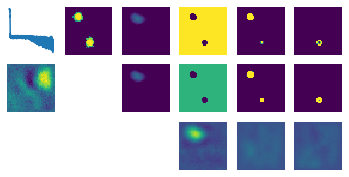

loss 24500 tensor(1.5618, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2790) >>><<
tensor(1.0000e-08) tensor(0.2790) >>><<
tensor(1.0000e-08) tensor(0.2790) >>><<


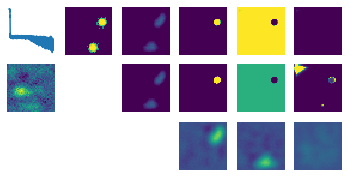

tensor(1.0000e-08) tensor(0.0674) >>><<
tensor(1.0000e-08) tensor(0.0674) >>><<
tensor(1.0000e-08) tensor(0.0674) >>><<


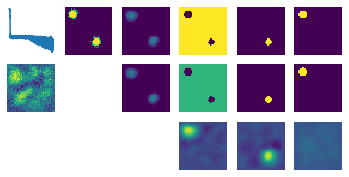

loss 24750 tensor(1.7270, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0592) >>><<
tensor(1.0000e-08) tensor(0.0592) >>><<
tensor(1.0000e-08) tensor(0.0592) >>><<


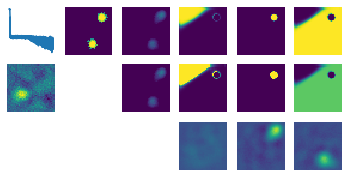

tensor(1.0000e-08) tensor(0.2171) >>><<
tensor(1.0000e-08) tensor(0.2171) >>><<
tensor(1.0000e-08) tensor(0.2171) >>><<


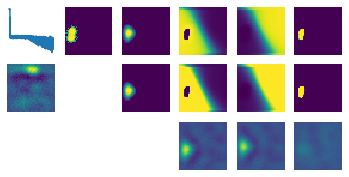

loss 25000 tensor(1.4780, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2086) >>><<
tensor(1.0000e-08) tensor(0.2086) >>><<
tensor(1.0000e-08) tensor(0.2086) >>><<


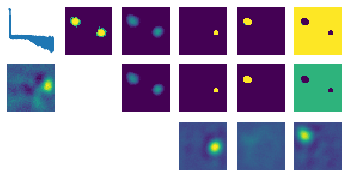

tensor(1.0000e-08) tensor(0.1045) >>><<
tensor(1.0000e-08) tensor(0.1045) >>><<
tensor(1.0000e-08) tensor(0.1045) >>><<


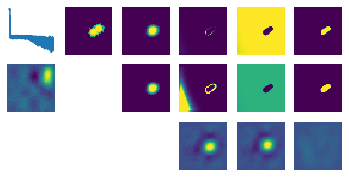

loss 25250 tensor(2.1874, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4839) >>><<
tensor(1.0000e-08) tensor(0.4839) >>><<
tensor(1.0000e-08) tensor(0.4839) >>><<


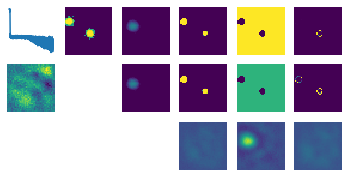

tensor(1.0000e-08) tensor(0.3927) >>><<
tensor(1.0000e-08) tensor(0.3927) >>><<
tensor(1.0000e-08) tensor(0.3927) >>><<


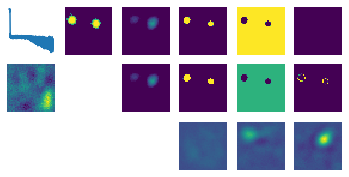

loss 25500 tensor(2.0220, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5411) >>><<
tensor(1.0000e-08) tensor(0.5411) >>><<
tensor(1.0000e-08) tensor(0.5411) >>><<


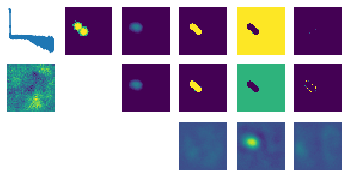

tensor(1.0000e-08) tensor(0.1052) >>><<
tensor(1.0000e-08) tensor(0.1052) >>><<
tensor(1.0000e-08) tensor(0.1052) >>><<


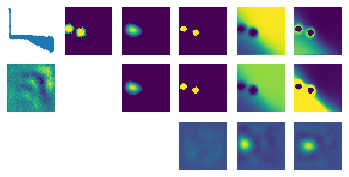

loss 25750 tensor(1.4821, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2611) >>><<
tensor(1.0000e-08) tensor(0.2611) >>><<
tensor(1.0000e-08) tensor(0.2611) >>><<


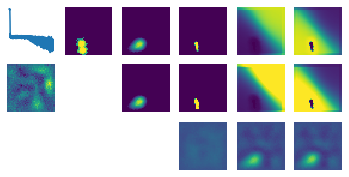

tensor(1.0000e-08) tensor(0.1794) >>><<
tensor(1.0000e-08) tensor(0.1794) >>><<
tensor(1.0000e-08) tensor(0.1794) >>><<


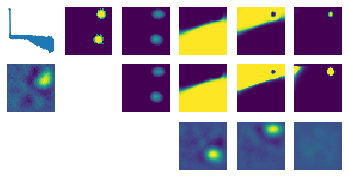

loss 26000 tensor(1.4065, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5513) >>><<
tensor(1.0000e-08) tensor(0.5513) >>><<
tensor(1.0000e-08) tensor(0.5513) >>><<


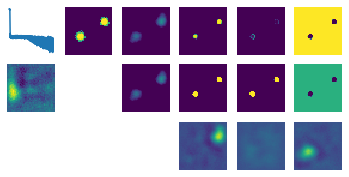

tensor(1.0000e-08) tensor(0.6022) >>><<
tensor(1.0000e-08) tensor(0.6022) >>><<
tensor(1.0000e-08) tensor(0.6022) >>><<


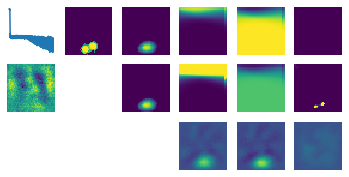

loss 26250 tensor(1.2717, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2800) >>><<
tensor(1.0000e-08) tensor(0.2800) >>><<
tensor(1.0000e-08) tensor(0.2800) >>><<


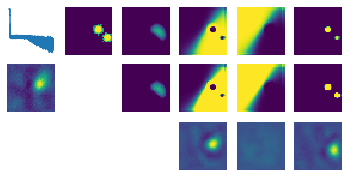

tensor(1.0000e-08) tensor(0.4379) >>><<
tensor(1.0000e-08) tensor(0.4379) >>><<
tensor(1.0000e-08) tensor(0.4379) >>><<


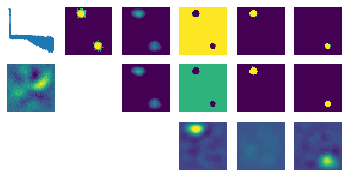

loss 26500 tensor(1.8724, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2023) >>><<
tensor(1.0000e-08) tensor(0.2023) >>><<
tensor(1.0000e-08) tensor(0.2023) >>><<


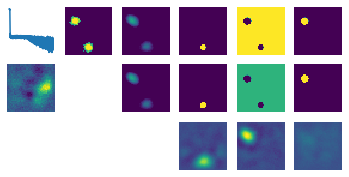

tensor(1.0000e-08) tensor(0.1735) >>><<
tensor(1.0000e-08) tensor(0.1735) >>><<
tensor(1.0000e-08) tensor(0.1735) >>><<


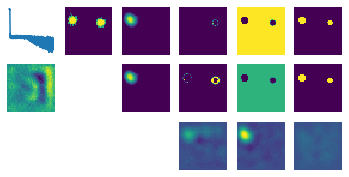

loss 26750 tensor(1.4536, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1354) >>><<
tensor(1.0000e-08) tensor(0.1354) >>><<
tensor(1.0000e-08) tensor(0.1354) >>><<


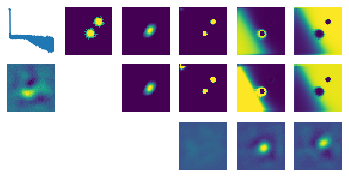

tensor(1.0000e-08) tensor(0.1012) >>><<
tensor(1.0000e-08) tensor(0.1012) >>><<
tensor(1.0000e-08) tensor(0.1012) >>><<


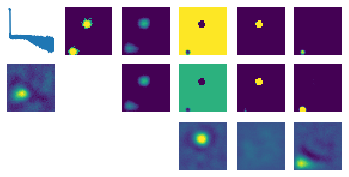

loss 27000 tensor(1.7923, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5206) >>><<
tensor(1.0000e-08) tensor(0.5206) >>><<
tensor(1.0000e-08) tensor(0.5206) >>><<


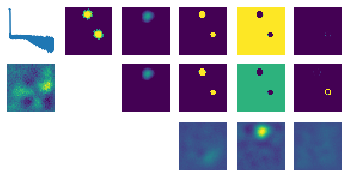

tensor(1.0000e-08) tensor(0.1497) >>><<
tensor(1.0000e-08) tensor(0.1497) >>><<
tensor(1.0000e-08) tensor(0.1497) >>><<


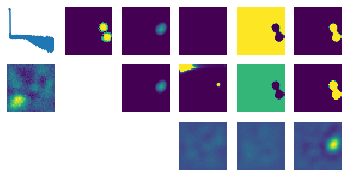

loss 27250 tensor(1.2617, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0614) >>><<
tensor(1.0000e-08) tensor(0.0614) >>><<
tensor(1.0000e-08) tensor(0.0614) >>><<


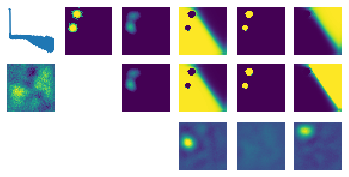

tensor(1.0000e-08) tensor(0.2554) >>><<
tensor(1.0000e-08) tensor(0.2554) >>><<
tensor(1.0000e-08) tensor(0.2554) >>><<


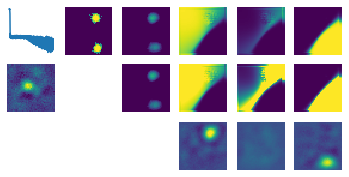

loss 27500 tensor(1.6363, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1253) >>><<
tensor(1.0000e-08) tensor(0.1253) >>><<
tensor(1.0000e-08) tensor(0.1253) >>><<


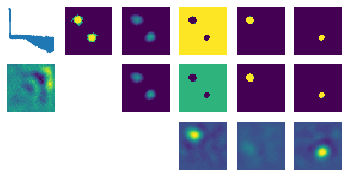

tensor(1.0000e-08) tensor(0.1179) >>><<
tensor(1.0000e-08) tensor(0.1179) >>><<
tensor(1.0000e-08) tensor(0.1179) >>><<


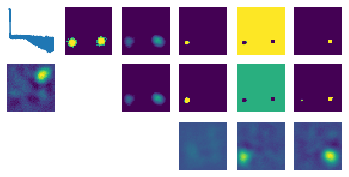

loss 27750 tensor(1.7819, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4807) >>><<
tensor(1.0000e-08) tensor(0.4807) >>><<
tensor(1.0000e-08) tensor(0.4807) >>><<


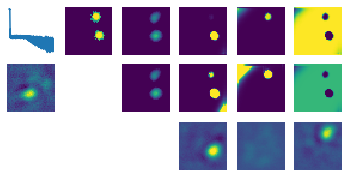

tensor(1.0000e-08) tensor(0.2789) >>><<
tensor(1.0000e-08) tensor(0.2789) >>><<
tensor(1.0000e-08) tensor(0.2789) >>><<


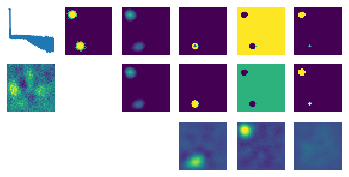

loss 28000 tensor(1.8547, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0621) >>><<
tensor(1.0000e-08) tensor(0.0621) >>><<
tensor(1.0000e-08) tensor(0.0621) >>><<


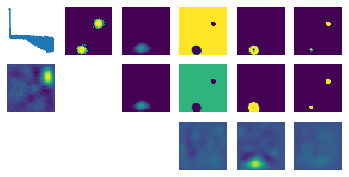

tensor(1.0000e-08) tensor(0.3009) >>><<
tensor(1.0000e-08) tensor(0.3009) >>><<
tensor(1.0000e-08) tensor(0.3009) >>><<


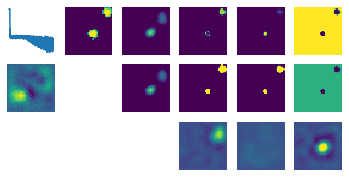

loss 28250 tensor(1.7704, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0734) >>><<
tensor(1.0000e-08) tensor(0.0734) >>><<
tensor(1.0000e-08) tensor(0.0734) >>><<


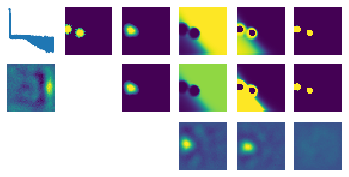

tensor(1.0000e-08) tensor(0.6132) >>><<
tensor(1.0000e-08) tensor(0.6132) >>><<
tensor(1.0000e-08) tensor(0.6132) >>><<


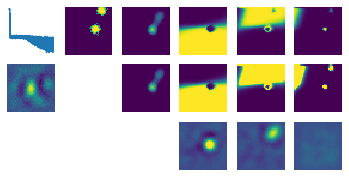

loss 28500 tensor(1.9482, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1943) >>><<
tensor(1.0000e-08) tensor(0.1943) >>><<
tensor(1.0000e-08) tensor(0.1943) >>><<


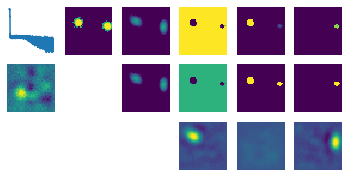

tensor(1.0000e-08) tensor(0.1585) >>><<
tensor(1.0000e-08) tensor(0.1585) >>><<
tensor(1.0000e-08) tensor(0.1585) >>><<


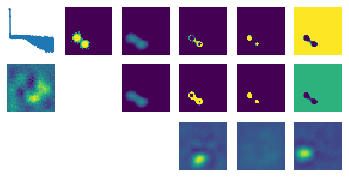

loss 28750 tensor(1.7916, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4817) >>><<
tensor(1.0000e-08) tensor(0.4817) >>><<
tensor(1.0000e-08) tensor(0.4817) >>><<


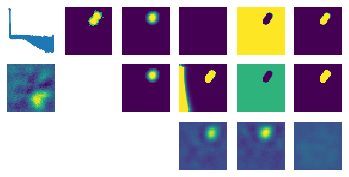

tensor(1.0000e-08) tensor(0.5446) >>><<
tensor(1.0000e-08) tensor(0.5446) >>><<
tensor(1.0000e-08) tensor(0.5446) >>><<


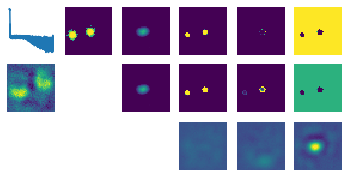

loss 29000 tensor(1.5820, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5092) >>><<
tensor(1.0000e-08) tensor(0.5092) >>><<
tensor(1.0000e-08) tensor(0.5092) >>><<


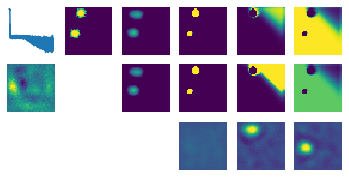

tensor(1.0000e-08) tensor(0.1113) >>><<
tensor(1.0000e-08) tensor(0.1113) >>><<
tensor(1.0000e-08) tensor(0.1113) >>><<


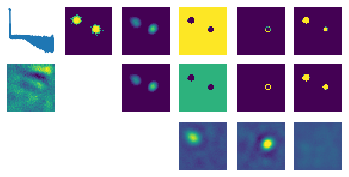

loss 29250 tensor(1.8076, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1642) >>><<
tensor(1.0000e-08) tensor(0.1642) >>><<
tensor(1.0000e-08) tensor(0.1642) >>><<


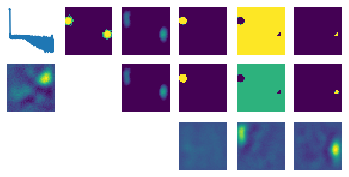

tensor(1.0000e-08) tensor(0.2507) >>><<
tensor(1.0000e-08) tensor(0.2507) >>><<
tensor(1.0000e-08) tensor(0.2507) >>><<


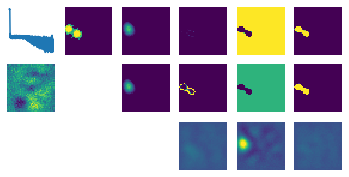

loss 29500 tensor(1.9023, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.0841) >>><<
tensor(1.0000e-08) tensor(0.0841) >>><<
tensor(1.0000e-08) tensor(0.0841) >>><<


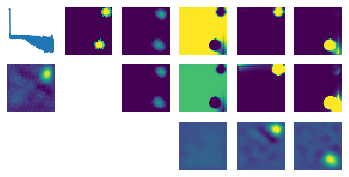

tensor(1.0000e-08) tensor(0.1459) >>><<
tensor(1.0000e-08) tensor(0.1459) >>><<
tensor(1.0000e-08) tensor(0.1459) >>><<


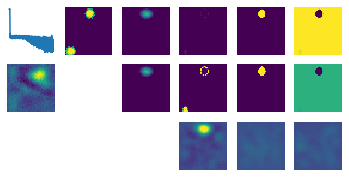

loss 29750 tensor(1.3575, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5231) >>><<
tensor(1.0000e-08) tensor(0.5231) >>><<
tensor(1.0000e-08) tensor(0.5231) >>><<


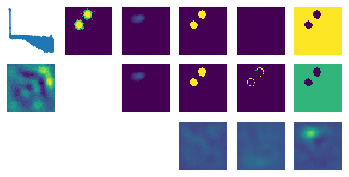

tensor(1.0000e-08) tensor(0.1107) >>><<
tensor(1.0000e-08) tensor(0.1107) >>><<
tensor(1.0000e-08) tensor(0.1107) >>><<


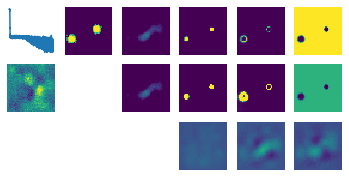

loss 30000 tensor(1.1256, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5185) >>><<
tensor(1.0000e-08) tensor(0.5185) >>><<
tensor(1.0000e-08) tensor(0.5185) >>><<


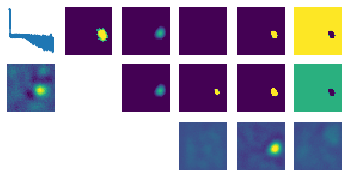

tensor(1.0000e-08) tensor(0.6264) >>><<
tensor(1.0000e-08) tensor(0.6264) >>><<
tensor(1.0000e-08) tensor(0.6264) >>><<


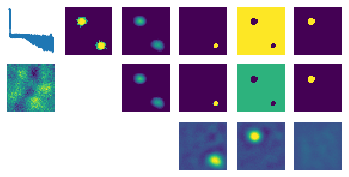

loss 30250 tensor(1.5466, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3202) >>><<
tensor(1.0000e-08) tensor(0.3202) >>><<
tensor(1.0000e-08) tensor(0.3202) >>><<


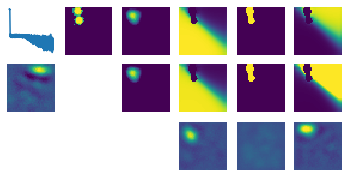

tensor(1.0000e-08) tensor(0.5546) >>><<
tensor(1.0000e-08) tensor(0.5546) >>><<
tensor(1.0000e-08) tensor(0.5546) >>><<


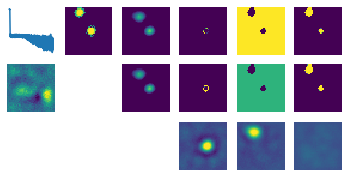

loss 30500 tensor(1.9286, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1830) >>><<
tensor(1.0000e-08) tensor(0.1830) >>><<
tensor(1.0000e-08) tensor(0.1830) >>><<


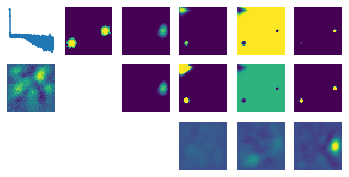

tensor(1.0000e-08) tensor(0.3156) >>><<
tensor(1.0000e-08) tensor(0.3156) >>><<
tensor(1.0000e-08) tensor(0.3156) >>><<


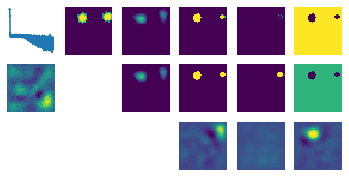

loss 30750 tensor(1.4321, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4396) >>><<
tensor(1.0000e-08) tensor(0.4396) >>><<
tensor(1.0000e-08) tensor(0.4396) >>><<


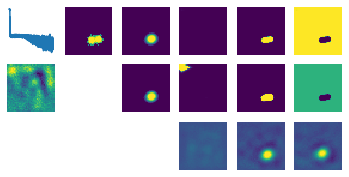

tensor(1.0000e-08) tensor(0.4864) >>><<
tensor(1.0000e-08) tensor(0.4864) >>><<
tensor(1.0000e-08) tensor(0.4864) >>><<


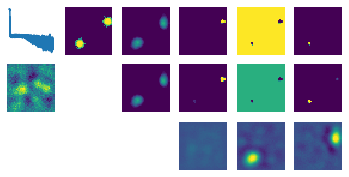

loss 31000 tensor(1.3724, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2966) >>><<
tensor(1.0000e-08) tensor(0.2966) >>><<
tensor(1.0000e-08) tensor(0.2966) >>><<


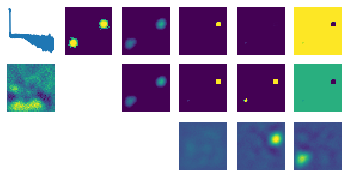

tensor(1.0000e-08) tensor(0.2225) >>><<
tensor(1.0000e-08) tensor(0.2225) >>><<
tensor(1.0000e-08) tensor(0.2225) >>><<


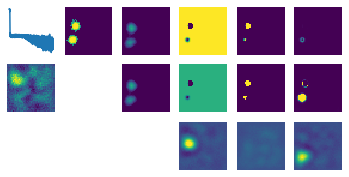

loss 31250 tensor(1.2193, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1013) >>><<
tensor(1.0000e-08) tensor(0.1013) >>><<
tensor(1.0000e-08) tensor(0.1013) >>><<


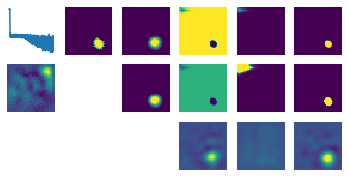

tensor(1.0000e-08) tensor(0.5086) >>><<
tensor(1.0000e-08) tensor(0.5086) >>><<
tensor(1.0000e-08) tensor(0.5086) >>><<


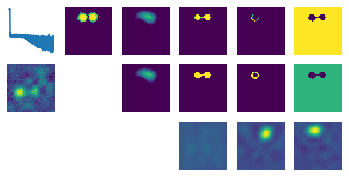

loss 31500 tensor(1.8087, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5528) >>><<
tensor(1.0000e-08) tensor(0.5528) >>><<
tensor(1.0000e-08) tensor(0.5528) >>><<


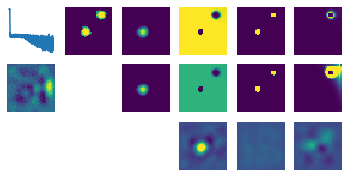

tensor(1.0000e-08) tensor(0.1464) >>><<
tensor(1.0000e-08) tensor(0.1464) >>><<
tensor(1.0000e-08) tensor(0.1464) >>><<


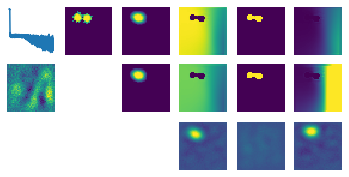

loss 31750 tensor(1.4551, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1459) >>><<
tensor(1.0000e-08) tensor(0.1459) >>><<
tensor(1.0000e-08) tensor(0.1459) >>><<


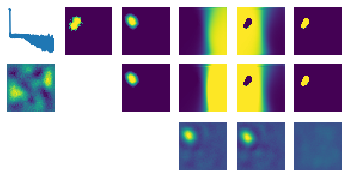

tensor(1.0000e-08) tensor(0.6751) >>><<
tensor(1.0000e-08) tensor(0.6751) >>><<
tensor(1.0000e-08) tensor(0.6751) >>><<


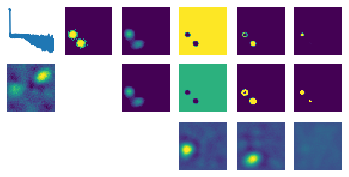

loss 32000 tensor(1.3594, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4413) >>><<
tensor(1.0000e-08) tensor(0.4413) >>><<
tensor(1.0000e-08) tensor(0.4413) >>><<


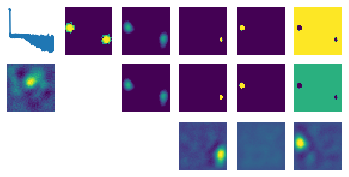

tensor(1.0000e-08) tensor(0.4594) >>><<
tensor(1.0000e-08) tensor(0.4594) >>><<
tensor(1.0000e-08) tensor(0.4594) >>><<


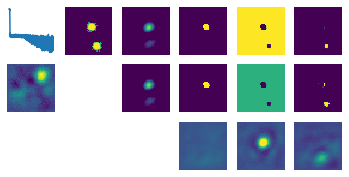

loss 32250 tensor(1.9884, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5252) >>><<
tensor(1.0000e-08) tensor(0.5252) >>><<
tensor(1.0000e-08) tensor(0.5252) >>><<


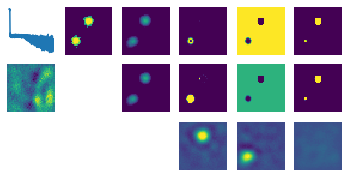

tensor(1.0000e-08) tensor(0.3008) >>><<
tensor(1.0000e-08) tensor(0.3008) >>><<
tensor(1.0000e-08) tensor(0.3008) >>><<


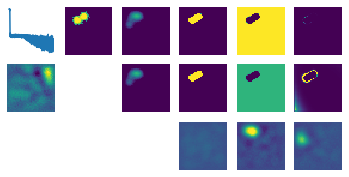

loss 32500 tensor(1.2252, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2166) >>><<
tensor(1.0000e-08) tensor(0.2166) >>><<
tensor(1.0000e-08) tensor(0.2166) >>><<


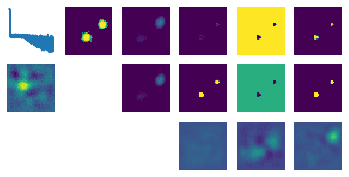

tensor(1.0000e-08) tensor(0.1970) >>><<
tensor(1.0000e-08) tensor(0.1970) >>><<
tensor(1.0000e-08) tensor(0.1970) >>><<


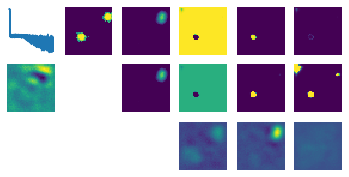

loss 32750 tensor(1.6978, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3932) >>><<
tensor(1.0000e-08) tensor(0.3932) >>><<
tensor(1.0000e-08) tensor(0.3932) >>><<


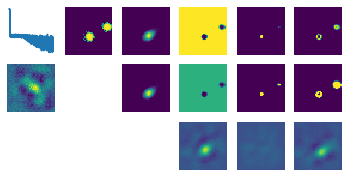

tensor(1.0000e-08) tensor(0.2751) >>><<
tensor(1.0000e-08) tensor(0.2751) >>><<
tensor(1.0000e-08) tensor(0.2751) >>><<


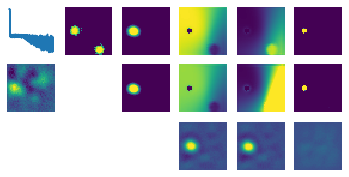

loss 33000 tensor(1.3307, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1608) >>><<
tensor(1.0000e-08) tensor(0.1608) >>><<
tensor(1.0000e-08) tensor(0.1608) >>><<


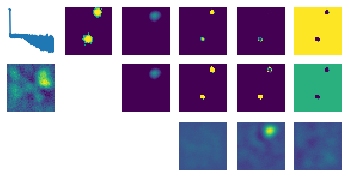

tensor(1.0000e-08) tensor(0.3784) >>><<
tensor(1.0000e-08) tensor(0.3784) >>><<
tensor(1.0000e-08) tensor(0.3784) >>><<


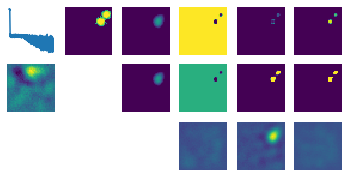

loss 33250 tensor(2.2728, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2574) >>><<
tensor(1.0000e-08) tensor(0.2574) >>><<
tensor(1.0000e-08) tensor(0.2574) >>><<


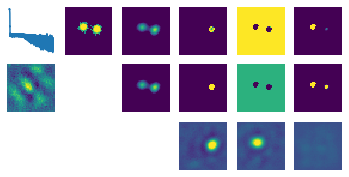

tensor(1.0000e-08) tensor(0.4496) >>><<
tensor(1.0000e-08) tensor(0.4496) >>><<
tensor(1.0000e-08) tensor(0.4496) >>><<


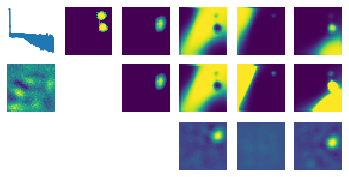

loss 33500 tensor(1.1936, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3496) >>><<
tensor(1.0000e-08) tensor(0.3496) >>><<
tensor(1.0000e-08) tensor(0.3496) >>><<


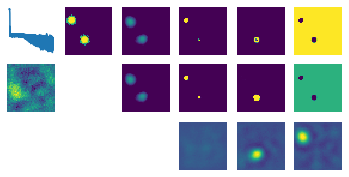

tensor(1.0000e-08) tensor(0.0792) >>><<
tensor(1.0000e-08) tensor(0.0792) >>><<
tensor(1.0000e-08) tensor(0.0792) >>><<


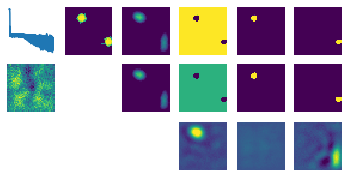

loss 33750 tensor(1.5461, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.7604) >>><<
tensor(1.0000e-08) tensor(0.7604) >>><<
tensor(1.0000e-08) tensor(0.7604) >>><<


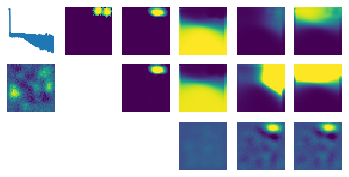

tensor(1.0000e-08) tensor(0.4919) >>><<
tensor(1.0000e-08) tensor(0.4919) >>><<
tensor(1.0000e-08) tensor(0.4919) >>><<


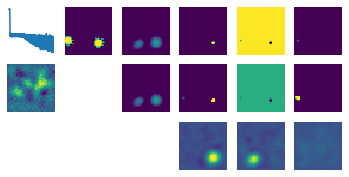

loss 34000 tensor(1.8317, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5616) >>><<
tensor(1.0000e-08) tensor(0.5616) >>><<
tensor(1.0000e-08) tensor(0.5616) >>><<


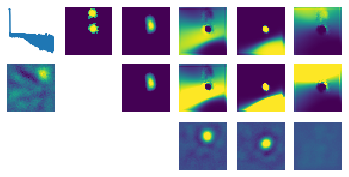

tensor(1.0000e-08) tensor(0.5294) >>><<
tensor(1.0000e-08) tensor(0.5294) >>><<
tensor(1.0000e-08) tensor(0.5294) >>><<


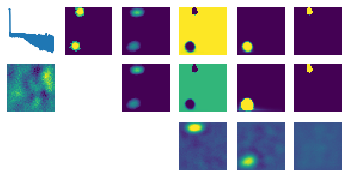

loss 34250 tensor(1.6458, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2061) >>><<
tensor(1.0000e-08) tensor(0.2061) >>><<
tensor(1.0000e-08) tensor(0.2061) >>><<


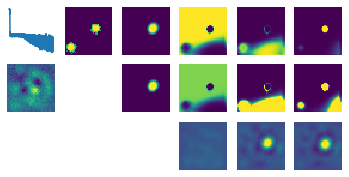

tensor(1.0000e-08) tensor(0.1553) >>><<
tensor(1.0000e-08) tensor(0.1553) >>><<
tensor(1.0000e-08) tensor(0.1553) >>><<


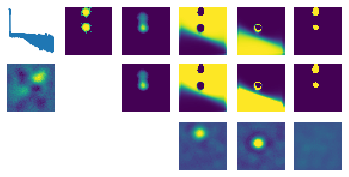

loss 34500 tensor(1.5164, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1669) >>><<
tensor(1.0000e-08) tensor(0.1669) >>><<
tensor(1.0000e-08) tensor(0.1669) >>><<


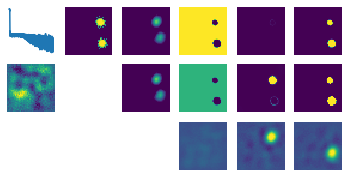

tensor(1.0000e-08) tensor(0.2677) >>><<
tensor(1.0000e-08) tensor(0.2677) >>><<
tensor(1.0000e-08) tensor(0.2677) >>><<


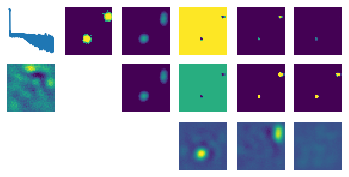

loss 34750 tensor(1.9608, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.3187) >>><<
tensor(1.0000e-08) tensor(0.3187) >>><<
tensor(1.0000e-08) tensor(0.3187) >>><<


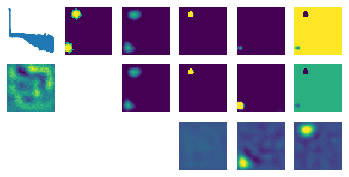

tensor(1.0000e-08) tensor(0.1423) >>><<
tensor(1.0000e-08) tensor(0.1423) >>><<
tensor(1.0000e-08) tensor(0.1423) >>><<


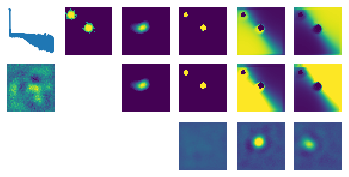

loss 35000 tensor(1.5785, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.4784) >>><<
tensor(1.0000e-08) tensor(0.4784) >>><<
tensor(1.0000e-08) tensor(0.4784) >>><<


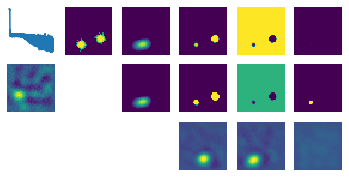

tensor(1.0000e-08) tensor(0.6957) >>><<
tensor(1.0000e-08) tensor(0.6957) >>><<
tensor(1.0000e-08) tensor(0.6957) >>><<


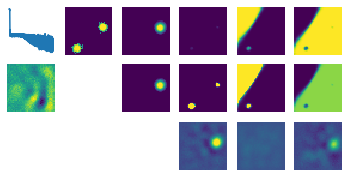

loss 35250 tensor(1.1327, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.1455) >>><<
tensor(1.0000e-08) tensor(0.1455) >>><<
tensor(1.0000e-08) tensor(0.1455) >>><<


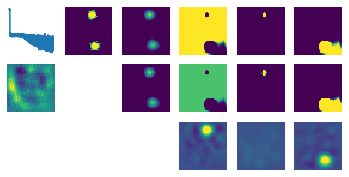

tensor(1.0000e-08) tensor(0.4175) >>><<
tensor(1.0000e-08) tensor(0.4175) >>><<
tensor(1.0000e-08) tensor(0.4175) >>><<


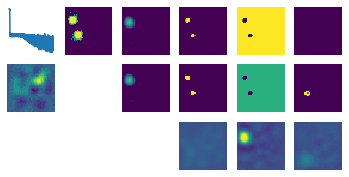

loss 35500 tensor(1.2142, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5124) >>><<
tensor(1.0000e-08) tensor(0.5124) >>><<
tensor(1.0000e-08) tensor(0.5124) >>><<


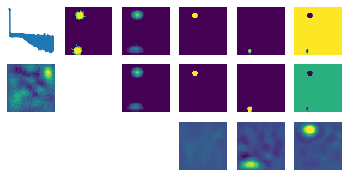

tensor(1.0000e-08) tensor(0.3160) >>><<
tensor(1.0000e-08) tensor(0.3160) >>><<
tensor(1.0000e-08) tensor(0.3160) >>><<


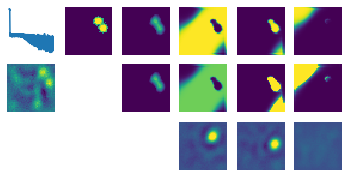

loss 35750 tensor(1.9112, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.2277) >>><<
tensor(1.0000e-08) tensor(0.2277) >>><<
tensor(1.0000e-08) tensor(0.2277) >>><<


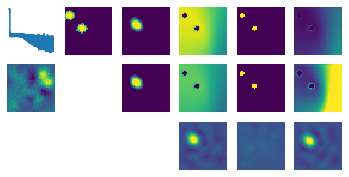

tensor(1.0000e-08) tensor(0.3312) >>><<
tensor(1.0000e-08) tensor(0.3312) >>><<
tensor(1.0000e-08) tensor(0.3312) >>><<
loss 36000 tensor(1.5919, grad_fn=<MseLossBackward0>) 0.0003
tensor(1.0000e-08) tensor(0.5354) >>><<
tensor(1.0000e-08) tensor(0.5354) >>><<
tensor(1.0000e-08) tensor(0.5354) >>><<


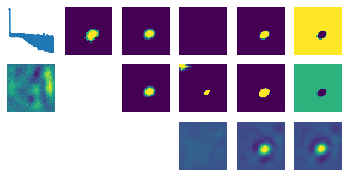

tensor(1.0000e-08) tensor(0.4828) >>><<
tensor(1.0000e-08) tensor(0.4828) >>><<
tensor(1.0000e-08) tensor(0.4828) >>><<


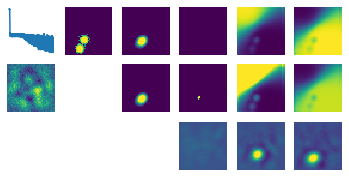

In [ ]:
model,*_rest = train(model,40_000)